# Antenna Measurement via Near- to Far-Field Transformation

This Jupiter notebook was developed as part of the bachelor thesis "Antenna Measurement via Near- to Far-Field Transformation".  
The code includes the derivation of far-field-patterns (FFP) from a planar measurmentes of directive antennas and everything that is needed for their comparison to a spherical state-of-the-art-measurement (SOTA-measurement).

It is clustered in following blocks:
1. Functions for reading and transforming data, for the derivation and the comparison of FFPs and helper routines
2. Functions for plotting derived data which also are responsible for storing the plots to topic-related locations
3. Execution of derivation, comparison and plotting of the FFPs

## 1. Functions for reading and transforming data, for the derivation and the comparison of FFPs and helper routines.

This cluster includes following sections:
* Libraries
* Read two dimensional JSON-arrays
* Reading in all planar measurement data
* Reading in all spheric SOTA-measurement data
* Create two dimensional array for representation of the spheric measurement
* Check planar measurments for errors and solution functionalities
* Helper routines
* FF-transformations via fast Fourier-transformation adapted to the used literature "Near-Field Antenna Measurements"
* Shift the measurment-plane to the corresponding aperture-plane
* Derivation of the FFP
* Zero-padding for a finer approximation of  for example local extrema
* Comparison of FFPs of planar measurements
* Interpolation derived from the scattert points of thetas and phis that are related to the planar data. <span style="color:red">Don't use it, because of outdated functionalities.</span>
* Planewave-condition and wavenumnbers depending on angles theta and phi
* Spheric representation using <span style="color:green"> (correct) </span> interpolation functionality scipy.interpolate.griddata


In [3]:
'''
Libraries
'''
import json
import cmath
import math
import unicodedata
import re

# numpy functionalities
import numpy as np
np.seterr(all='print') # Deactivate warnigs for example log10. 

# matplot functionalities
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors

# scipy functionalities
import scipy.constants as const
from scipy.interpolate import griddata




'''
Read two dimensional JSON-arrays
'''
def readJsonFile(jsonFilePath):
    # Information about our data:
    # It is a two dimenisonal array where each element is an tuple of Ex and Ey.
    # Ex and Ey each are tuples of real- (Re) and imaginary-parts (Im).
    # Re and Im each are lists of 91 frequencies from 8 to 12.5GHz in 50MHz-steps.
    
    # Get data from JSON-File
    f = open(jsonFilePath)
    data = json.load(f)
    f.close()
    
    # Create 2-dimensional Array with numpy and return it
    return np.array(data)

def create2dimArrayFromDistance(arrayWithDicts, distance, polarisaton, p_abs=False, phase=False):
    arr2dimPoints = np.arange(28**2, dtype=float).reshape(28,28)
    
    # Calculate our representation-list-point for our frequency (Exsample 12GHz: postion 80 of 91 in list)
    if p_abs:
        # Fill our createt array with abs of the passed dict-array which represents the measured data
        for m in range(28):
            for n in range(28):
                Ex = np.sqrt(arrayWithDicts[m][n]['Ex']['Re'][80]**2 + arrayWithDicts[m][n]['Ex']['Im'][80]**2)
                Ey = np.sqrt(arrayWithDicts[m][n]['Ey']['Re'][80]**2 + arrayWithDicts[m][n]['Ey']['Im'][80]**2)
                arr2dimPoints[m][n] = 20*np.log10(np.sqrt(Ex**2+Ey**2))
                
        print("Note: Phase will be ignored if it was set true! Make an extra array")
    elif phase:
        # Fill our createt array with phase of the passed dict-array which represents the measured data
        for m in range(28):
            for n in range(28):
                z = complex(arrayWithDicts[m][n][polarisaton]['Re'][80],arrayWithDicts[m][n][polarisaton]['Im'][80])
                arr2dimPoints[m][n] = np.angle(z,False)*180/np.pi
    else:
        print("Error: No abs or phase passed!")
    
    return arr2dimPoints

def transformDictArrayToComplexArray(arr, polarisation, frequency=80):
    if polarisation == 'Ex' or polarisation == 'Ey':
        complexArray = np.arange(28*28, dtype=complex).reshape(28,28)
        # Calculate fourierResult from 2-dimensional-array
        for n in range(28):
            for m in range(28):
                # Prepare values for complex multiplication
                complexArray[n][m] = complex(arr[n][m][polarisation]['Re'][frequency],arr[n][m][polarisation]['Im'][frequency])
    else:
        print("Error")
    return complexArray

def save2dimDictArrayAsJSON(dictArray2dim, frequencyRepresentant, fileName):
    '''This function takes a specific frequency from our read in data represented as dictionary, transforms it to a JSON and saves it at a specifc location'''
    Ex = np.arange(28**2,dtype=object).reshape(28,28)
    Ey = np.arange(28**2,dtype=object).reshape(28,28)
    
    for m in range(28):
        for n in range(28):
            Ex[m][n] = (dictArray2dim[m][n]['Ex']['Re'][frequencyRepresentant],dictArray2dim[m][n]['Ex']['Im'][frequencyRepresentant])
            Ey[m][n] = (dictArray2dim[m][n]['Ey']['Re'][frequencyRepresentant],dictArray2dim[m][n]['Ey']['Im'][frequencyRepresentant])
    
    arrayToSave = [ Ex.tolist() , Ey.tolist() ]
    
    path = r'C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\09_MatLab\Daten_zur_Überprüfung'
    file = '\\'+fileName+'.json'
    with open(path+file, 'w') as f:
        jsonData = json.dump(arrayToSave, f)




'''
Reading in all planar measurement data
'''
def readMeasurmentData():
    # Read in all data
    path = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\09_MatLab\2022_06_03_final\Measurements"
    arr2dim25mm = readJsonFile(path+r"\measurePlaneData_distance25mm.json")
    arr2dim37p5mm = readJsonFile(path+r"\measurePlaneData_distance37-5mm.json")
    arr2dim50mm = readJsonFile(path+r"\measurePlaneData_distance50mm.json")
    arr2dim62p5mm = readJsonFile(path+r"\measurePlaneData_distance62-5mm.json")
    arr2dim75mm = readJsonFile(path+r"\measurePlaneData_distance75mm.json")
    arr2dim87p5mm = readJsonFile(path+r"\measurePlaneData_distance87-5mm.json")
    arr2dim100mm = readJsonFile(path+r"\measurePlaneData_distance100mm.json")
    arr2dim112p5mm = readJsonFile(path+r"\measurePlaneData_distance112-5mm.json")
    arr2dim125mm = readJsonFile(path+r"\measurePlaneData_distance125mm.json")
    arr2dim137p5mm = readJsonFile(path+r"\measurePlaneData_distance137-5mm.json")
    arr2dim150mm = readJsonFile(path+r"\measurePlaneData_distance150mm.json")

    measurements = [ # array distance 0 to 10 -> 11 measurements
                        arr2dim25mm,
                        arr2dim37p5mm,
                        arr2dim50mm,
                        arr2dim62p5mm,
                        arr2dim75mm,
                        arr2dim87p5mm,
                        arr2dim100mm,
                        arr2dim112p5mm,
                        arr2dim125mm,
                        arr2dim137p5mm,
                        arr2dim150mm
                   ]
    return measurements

def transformMeasurmentsToComplex(measurements, frequency=80):
    measurementsInComplex = []
    for i in range(11):
        polarisations = [transformDictArrayToComplexArray(measurements[i],'Ex',frequency),transformDictArrayToComplexArray(measurements[i],'Ey',frequency)]
        measurementsInComplex.append(polarisations)
        
    return measurementsInComplex

def getSpecificMeasurement(measurements, distance=0, frequency=80):
    complexMeasurmentTuple = [ transformDictArrayToComplexArray(measurements[distance],'Ex',frequency), transformDictArrayToComplexArray(measurements[distance],'Ey',frequency) ]
    return complexMeasurmentTuple





'''
Reading in all spheric SOTA-measurement data
'''
def transformLineToCSV(line):
    '''
    Exchanges multiple spaces to one comma to create a csv-line.
    '''
    import re
    # Remove unnecessary characters from the beginning and the end of the line
    line = line.strip()
    # Remove unnecessary spaces
    line = re.sub(' +', ' ', line)
    # Replace spaces with commas
    line = line.replace(' ', ',')
    
    return line

def readTextFileAndCreateString(txtName):
    '''
    Reads a text file at a specific location line by line and creates a CSV storeable string.
    The text file is identified by its name.
    '''
    path = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\12_State-of-the-Art-Messung"
    pathToFile = path+'\\'+txtName
    
    f = open(pathToFile,"r")
    line = f.readline() # first line is the header and not needed
    measurementData = ''
    while line != '':
        line = f.readline()
        line = transformLineToCSV(line)
        measurementData = measurementData+line+"\n"
        
    f.close()
        
    return measurementData

def storeStringAsCSV(data,csvName):
    '''
    Stores a given string to a csv-file at a fixed loacation.
    '''
    # Store csv
    csvPath = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\12_State-of-the-Art-Messung\csv_data"
    pathToFile = csvPath+'\\'+csvName

    f = open(pathToFile,'w')
    f.write(data)
    f.close()

# Create a dict-object-representation of a measurement point
def createMeasurementPointDict(theta, phi, amp, phase):
    '''
    Creates a dictonary object from a given measurement point related to theta and phi.
    '''
    measurementPoint = {'theta':theta,
                        'phi':phi,
                        'amp_dB':amp,
                        'phase':phase
                        }
    return measurementPoint

# Create dict representation of CSV-file
def createListOfDictObjectsFromCSV(csvName):
    '''
    Creates a dictionary object list from csv file at a specific location identified through its name.
    '''
    import csv
    
    csvPath = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\12_State-of-the-Art-Messung\csv_data"
    pathToFile = csvPath+'\\'+csvName

    dictObjects = []
    csvFile = open(pathToFile)
    lines = csv.reader(csvFile)

    for line in lines:
        if len(line) == 4:
            dictObject = createMeasurementPointDict(line[0],line[1],line[2],line[3])
            dictObjects.append(dictObject)
    csvFile.close()
    
    return dictObjects
    
# Store dictObjects to a JSON-File
def storeDictObjectsToJSON(dictObjects, measurementName):
    import json
    jsonPath = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\12_State-of-the-Art-Messung\json_data"
    pathToFile = jsonPath+'\\'+measurementName
    
    with open(pathToFile, 'w') as fp:
        json.dump(dictObjects, fp)

# 2.5GHz -steps
def transformMeasurementDataToCSVandJSON():
    for i in range(19):
        # Calculate freqeuncy
        frequency = 8_000_000_000 + i*250_000_000
        frequency_GHz = frequency*10**(-9)

        # Create csv- and json-filenames
        CsvJsonFileNameP = "ffData_"+str(frequency_GHz).replace(".","-")+"GHz_p"
        CsvJsonFileNameX = "ffData_"+str(frequency_GHz).replace(".","-")+"GHz_x"
        CsvJsonFileNameP = slugify(CsvJsonFileNameP, allow_unicode=False)
        CsvJsonFileNameX = slugify(CsvJsonFileNameX, allow_unicode=False)

        # Create txt-file-names
        num = str(i+1).zfill(3)                         # for leading zeros
        txtFileNameP = "LA_10_1_ffdata_"+num+"p.txt"    # p-polarisation
        txtFileNameX = "LA_10_1_ffdata_"+num+"x.txt"    # x-polarisation

        # Read text-file and create csv-storeable string
        measurementDataP = readTextFileAndCreateString(txtFileNameP)
        measurementDataX = readTextFileAndCreateString(txtFileNameX)

        # Create csv-file
        storeStringAsCSV(measurementDataP,CsvJsonFileNameP+".csv")
        storeStringAsCSV(measurementDataX,CsvJsonFileNameX+".csv")

        # Create dictonary object representation from csv-file
        dictObjectsP = createListOfDictObjectsFromCSV(CsvJsonFileNameP+".csv")
        dictObjectsX = createListOfDictObjectsFromCSV(CsvJsonFileNameX+".csv")

        # Store dictonary objects as json-file
        storeDictObjectsToJSON(dictObjectsP,CsvJsonFileNameP+".json")
        storeDictObjectsToJSON(dictObjectsX,CsvJsonFileNameX+".json")

        print(str(i+1)+". iteration succsessful")






'''
Create two dimensional array for representation of the spheric measurement
'''
def findAmplitudeAndPhaseOfSpecificAngles(sphericMeasurements, findTheta, findPhi):
    phi = int(float(measurement['phi']))
    theta = int(float(measurement['theta']))
    for measurement in sphericMeasurements:
        if findTheta == theta:
            if findPhi == phi:
                return [float(measurement['amp_dB']),float(measurement['phase'])]
    print("Could not find related angles")
    
def assignSphericMeasurementsToThetaPhiGrid(sphericMeasurements, phase=False):
    grid = np.arange(360*91, dtype=float).reshape(91,360)
    
    for measurement in sphericMeasurements:
        phi = int(float(measurement['phi']))
        theta = int(float(measurement['theta']))
        if phi < 360: # Because measurements of phi=0 should be equal to phi=360
            grid[theta][phi] = float(measurement['amp_dB' if not phase else 'phase'])
    
    return grid






'''
Check planar measurments for errors and solution functionalities

The following code is for checking for invalid data-points in our measurement-planes.
A invalid data-point is a measurement-point with the polariastion-data [Ex,Ey] = [0,0], because there should be at least noise be measured.
'''
def checkMeasurmentForInvalidData(measurementPlaneInComplex, measurementName):
    for i in range(28):
        for j in range(28):
            if measurementPlaneInComplex[0][i][j] == 0:
                print(measurementName+', Polarisation Ex, Punktindex ['+str(i)+']['+str(j)+']')
                
            if measurementPlaneInComplex[1][i][j] == 0:
                print(measurementName+', Polarisation Ey, Punktindex ['+str(i)+']['+str(j)+']')
                
def checkMeasurmentSpecificPolarisationForInvalidData(measurementPlaneInComplex, measurementName):
    for i in range(28):
        for j in range(28):
            if measurementPlaneInComplex[i][j] == 0:
                print(measurementName+', Polarisation Ex, Punktindex ['+str(i)+']['+str(j)+']')

def checkAllMeasurmentsForInvalidData(measurementsInComplex):
    distances = [ 25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 137.5, 150 ]
    for i in range(11):
        checkMeasurmentForInvalidData(measurementsInComplex[i],'Measurementplane@'+str(distances[i])+'mm')
        
def getMean(array, x, y):
    print('Replace invalid data with mean at position: ['+str(x)+']['+str(y)+']')
    # If there are singularities check if it is surounded by measurment-knodes
    mean = 0
    
    # Rules for borders
    if x == 0:
        if y == 0:
            return (array[x][y+1] + array[x+1][y+1] + array[x+1][y])/3
        if y == 27:
            return (array[x][y-1] + array[x+1][y] + array[x+1][y-1])/3

        return (array[x][y+1] + array[x][y-1] + array[x+1][y+1] + array[x+1][y] + array[x+1][y-1])/5

    if x == 27:
        if y == 0:
            return (array[x-1][y] + array[x-1][y+1] + array[x][y+1])/3
        if y == 27:
            return (array[x-1][y] + array[x-1][y-1] + array[x][y-1])/3
        
    if y == 0:
        if x == 0:
            return (array[x][y+1] + array[x+1][y+1] + array[x+1][y])/3
        if x == 27:
            return (array[x-1][y] + array[x-1][y+1] + array[x][y+1])/3

        return (array[x-1][y] + array[x-1][y+1] + array[x][y+1] + array[x+1][y+1] + array[x+1][y])/5

    if y == 27:
        if x == 0:
            return (array[x][y-1] + array[x+1][y] + array[x+1][y-1])/3
        if x == 27:
            return (array[x-1][y] + array[x-1][y-1] + array[x][y-1])/3

        return (array[x-1][y] + array[x-1][y-1] + array[x][y-1] + array[x+1][y] + array[x+1][y-1])/5

    # If the point is not at any border of the measurement-plane
    return (array[x-1][y] + array[x-1][y+1] + array[x-1][y-1]
            + array[x][y+1] + array[x][y-1]
            + array[x+1][y+1] + array[x+1][y] + array[x+1][y-1])/8

def removeSingularitiesFromData(measurement):
    # Check for 0-values in measurement, because there should be at least noise
    singularities = np.where(measurement == 0)
    numberOfSingularities = len(singularities[0])
    xAxe = singularities[0]
    yAxe = singularities[1]
    result = np.copy(measurement)
        
    # Calculate mean-value of the found knodes and replace the singularity with it
    mean = 0
    for i in range(numberOfSingularities):
        result[xAxe[i]][yAxe[i]] = getMean(measurement, xAxe[i], yAxe[i])
        
    return result






'''
Helper routines
'''
# function to convert to subscript
def get_sub(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    sub_s = "ₐ₈CDₑբGₕᵢⱼₖₗₘₙₒₚQᵣₛₜᵤᵥwₓᵧZₐ♭꜀ᑯₑբ₉ₕᵢⱼₖₗₘₙₒₚ૧ᵣₛₜᵤᵥwₓᵧ₂₀₁₂₃₄₅₆₇₈₉₊₋₌₍₎"
    res = x.maketrans(''.join(normal), ''.join(sub_s))
    return x.translate(res)

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

def percentageColorbar(reverse=False):
    c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
    if reverse:
        c.reverse()
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    return cmap

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

def toFloat(cArray, ptype = 'ABS', dB=True): # TODO type-parameter for abs or phase
    # Create an 28x28 float-array for the abs and the phasesc
    cols = len(cArray)
    rows = len(cArray[0])
    floatArray = np.arange(cols*rows, dtype=float).reshape(cols,rows)
    
    for i in range(cols):
        for j in range(rows):
            if ptype == 'ABS':
                if dB:
                    floatArray[i][j] = 20*np.log10(np.abs(cArray[i][j]))
                else:
                    floatArray[i][j] = np.abs(cArray[i][j])
            elif ptype == 'phase':
                floatArray[i][j] = cmath.polar(cArray[i][j])[1]*180/np.pi
            else:
                print('Wrong type of parameter')
                return None
    return floatArray

def caluclateFrequencyFromIndex(index, GHz=True):
    # f = 8GHz + index*0.05GHz
    result = 8+index*0.05
    if GHz:
        return result
    else:
        return result*10**9
    
def calculateMeasurementDistance(index, mm=True):
    # z = 25mm + index*12.5mm
    result = 0.025+index*0.0125
    if mm:
        return result*1000
    else:
        return result
    
def plotSimplePatternRep(pattern):
    M,N = pattern.shape

    x = dKx*np.linspace(-14,13,M+1)
    y = dKx*np.linspace(-14,13,N+1)
    X, Y = np.meshgrid(x, y)


    fig = plt.figure(figsize=(5, 4))
    ax1 = fig.add_subplot(111)
    image = plt.pcolormesh(X,Y,np.transpose(pattern))
    image.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(image, cax=cax, orientation='vertical').set_label("ABS (dB)")
    plt.show()

def appendFirstRowAndLastColumnOfPattern(pattern, dtype=complex):
    M,N = pattern.shape
    firstRow = np.zeros((1,N),dtype=dtype)
    pattern = np.append(pattern,firstRow,axis=0)
    pattern = np.roll(pattern,1,axis=0)

    lastColumn = np.zeros((M+1,1),dtype=dtype)
    pattern = np.append(pattern,lastColumn,axis=1)
    
    return pattern

def deleteFirstColumnAndLastrowOfPattern(pattern, dtype=complex):
    # Delete first column
    pattern = np.delete(pattern, 0, 1)
    # Delete last row
    pattern = np.delete(pattern, -1, 0)
    return pattern

def createComplexRepresentationOfMagnitudeAndPhase(magnitudes, phases, dB=True, deg=True):
    # Convertions
    magnitudes = 10**(magnitudes/20) if dB else magnitudes
    phases = np.radians(phases) if deg else phases
    
    # Components
    real = magnitudes*np.cos(phases)
    imag = magnitudes*np.sin(phases)
    
    # Create complex array
    M, N = magnitudes.shape
    complexRep = np.arange(M*N,dtype=complex).reshape(M,N)
    
    # Fill the complex array
    for i in range(M):
        for j in range(N):
            complexRep[i][j] = complex(real[i][j],imag[i][j])
    
    return complexRep

def shiftMeasurement(measurement_p, measurement_x, cols):
    return np.roll(measurement_p, shift=cols, axis=1), np.roll(measurement_x, shift=cols, axis=1)

def getAreaForNicerPlotting(values):
    # Get the greater maximum
    maximum = np.nanmax(values)
    
    # Get the smaller minimum
    minimum = np.nanmin(values)
    
    # Add a little additional space on the top and the bottom (5%)
    repArea = maximum - minimum # 100%
    additionalSpace = 12*repArea/100 #12%
    maximum = maximum + additionalSpace
    minimum = minimum - additionalSpace
    
    return minimum, maximum







'''
FF-transformations via fast Fourier-transformation adapted to the used literature "Near-Field Antenna Measurements"
'''
def aquireAmplitudeSpectrum(eArray):
    cols, rows = eArray.shape
    normalisation = cols*rows
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(eArray))*normalisation)*(0.0125)**2

def aquireSpatialFields(ampSepctrum):
    cols, rows = ampSepctrum.shape
    dKx = 2*np.pi/(cols*0.0125)
    dKy = 2*np.pi/(rows*0.0125)
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ampSepctrum)))*dKx*dKy/(4*np.pi**2)






'''
Shift the measurment-plane to the corresponding aperture-plane

To create compareable measurment-plots they have be looked at from the same plane (in z direction) in space. Especially for the phase of the measurements.
'''
def correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(eArrayMP, measurementDistanceFromAUT, frequency=12*10**9):
    '''
    This function corrects the field-data of the measurment-plane to the transmitting AUT-plane (Aperture).
    It is important to compare the antenna-patterns-results of the different measurement-plane-distances with each other.
    '''
    
    # Length of NxM-array (quadratic N=M)
    N = len(eArrayMP)
    
    # Create an empty complex 28*28-array
    shiftedAmpSp = np.arange(N**2,dtype=complex).reshape(N,N)
    
    # Calculate k0
    wavelength = const.c/frequency
    k0 = 2*np.pi/wavelength
    
    # Caclulate some grid-constants
    deltaX = 0.025/2         # equals deltaY
    dkx = 2*np.pi/(N*deltaX) # equals dky
    
    # Calculate the Fourier-transformation (amplitude-spectrum) of the measurement-plane-data.
    # Transformation with np-library (compare book to lib-functions)
    ampSp = aquireAmplitudeSpectrum(eArrayMP)
    
    # Correct the amplitude-spectrum to the AUT-aperture
    for i in range(N):
        for j in range(N):
            # Calculate kz from k0, kx and ky.
            kx = i*dkx - np.pi/deltaX
            ky = j*dkx - np.pi/deltaX
            
            # Not nessecery for the shift
            if k0**2 >= kx**2 + ky**2:
                kz = np.sqrt(k0**2-kx**2-ky**2)
                '''If kx and ky are zero kz is the largest and equals 80pi. In other words kz = k0'''
            else:
                shiftedAmpSp[i][j] = 0
                continue
            
            # Calculate the phase-shift-factor resulting from the distance between measurement- and AUT-plane.
            phaseShiftFactor = kz*measurementDistanceFromAUT
            factor = complex(cmath.cos(phaseShiftFactor),cmath.sin(phaseShiftFactor)) # TODO: check constant normalization

            # Multiply the Fourier-transformation with the phase-shift-factor to correct it
            shiftedAmpSp[i][j] = factor*ampSp[i][j]
            
    return aquireSpatialFields(shiftedAmpSp)

def defineBordersOfAmplitudeSpectrumRelatedToFrequency(ampSpectrum, frequency):
    N = len(ampSpectrum)
    
    # Calculate k0
    wavelength = const.c/frequency
    k0 = 2*np.pi/wavelength
    
    # Caclulate some grid-constants
    deltaX = 0.025/2         # equals deltaY
    dkx = 2*np.pi/(N*deltaX) # equals dky
    
    for i in range(N):
        for j in range(N):
            # Calculate kz from k0, kx and ky.
            kx = i*dkx - np.pi/deltaX
            ky = j*dkx - np.pi/deltaX
            
            # Not nessecery for the shift
            if not k0**2 >= kx**2 + ky**2:
                ampSpectrum[i][j] = float('NaN')
                
    return ampSpectrum






'''
Derivation of the FFP
'''
def createUVWarrays(lengthOf2dimQuadraticArray):
    uArray = np.arange(lengthOf2dimQuadraticArray**2,dtype=float).reshape(lengthOf2dimQuadraticArray,lengthOf2dimQuadraticArray)
    vArray = np.arange(lengthOf2dimQuadraticArray**2,dtype=float).reshape(lengthOf2dimQuadraticArray,lengthOf2dimQuadraticArray)
    wArray = np.arange(lengthOf2dimQuadraticArray**2,dtype=float).reshape(lengthOf2dimQuadraticArray,lengthOf2dimQuadraticArray)
    
    # Calculate k0
    wavelength = 0.025
    k0 = 2*np.pi/wavelength
    
    # Caclulate some grid-constants
    deltaX = wavelength/2       # equals deltaY
    dkx = 2*np.pi/(lengthOf2dimQuadraticArray*deltaX)   # equals dky
    
    for i in range(lengthOf2dimQuadraticArray):
        for j in range (lengthOf2dimQuadraticArray):
            uArray[i][j] = (i*dkx - np.pi/deltaX)/k0
            vArray[i][j] = (j*dkx - np.pi/deltaX)/k0
            
            if 1 >= uArray[i][j]**2+vArray[i][j]**2:
                wArray[i][j] = np.sqrt(1-uArray[i][j]**2-vArray[i][j]**2)
            else:
                # w is complex an should not be further used, because it is part of an evanescent field.
                wArray[i][j] = float('NaN')
                
    return uArray, vArray, wArray

def createSpacialWavenumbers(dimX, dimY):
    kxs = np.arange(dimX*dimY,dtype=float).reshape(dimX,dimY)
    kys = np.arange(dimX*dimY,dtype=float).reshape(dimX,dimY)
    kzs = np.arange(dimX*dimY,dtype=float).reshape(dimX,dimY)
    
    # Calculate k0
    wavelength = 0.025 # for fixed measurement-grid!
    k0 = 2*np.pi/wavelength # 251
    
    # Caclulate some grid-constants
    deltaX = wavelength/2       # equals deltaY
    deltaY = deltaX
    dkx = 2*np.pi/(dimX*deltaX) # 8.97
    dky = 2*np.pi/(dimY*deltaY)
    
    for i in range(dimX):
        for j in range (dimY):
            kxs[i][j] = (i*dkx - np.pi/deltaX)
            kys[i][j] = (j*dky - np.pi/deltaY)
            
            if k0**2 >= kxs[i][j]**2+kys[i][j]**2:
                kzs[i][j] = np.sqrt(k0**2-kxs[i][j]**2-kys[i][j]**2)
            else:
                # kz is complex which means that it is an evanescent field
                kzs[i][j] = 0 
                
    return kxs, kys, kzs

def calculateElectricalFieldVectorsForSpecifcR(amplitudeSpectrum, r=0):
    M, N = amplitudeSpectrum.shape
    eArray = np.arange(M*N,dtype=complex).reshape(M,N)
    wavelength = 0.025
    k0 = 2*np.pi/wavelength
    
    # Create a uvw-array size-related to the given eArray
    uvws = createUVWarrays(M)    
    
    # if r is zero, the convetional approach is used
    if r == 0:
        eArray = 1/(wavelength)*uvws[2]*amplitudeSpectrum
        for i in range(M):
            for j in range(N):
                eArray[i][j] = complex(0,eArray[i][j])
    else:
        eArray = 1/(wavelength*r)*uvws[2]*amplitudeSpectrum
        for i in range(M):
            for j in range(N):
                phase = -k0*r*(uvws[0][i][j]**2 + uvws[1][i][j]**2 + uvws[2][i][j]**2)
                phaseInComplex = complex(np.cos(phase),np.sin(phase))
                
                eArray[i][j] = phaseInComplex*eArray[i][j]
                eArray[i][j] = complex(0,eArray[i][j])
    
    return eArray

def calculateSpecificPhiFromUandV(u, v):
        if v > 0 and u >= 0:
            phi = np.arctan(v/u)*180/np.pi

        elif v >= 0 and u < 0:
            phi = np.arctan(v/u)*180/np.pi + 180

        elif v < 0 and u < 0:
            phi = np.arctan(v/u)*180/np.pi - 180

        elif v <= 0 and u >= 0:
            phi = np.arctan(v/u)*180/np.pi

        else:
            phi = float('NaN')
        
        return phi

def calculatePhiWithRespectToQuadrant(uvw):
    M, N = uvw.size
    phis = np.arange(28**2,dtype=float).reshape(28,28)
    
    for i in range(M):
        for j in range(N):
            phis[i][j] = calculateSpecificPhiFromUandV(uvw[0][i][j],uvw[1][i][j])
                
    return phis

# function for creating ff-pattern from distance measurements
def getFarFieldPattern(measurment, distance, frequency, zp=0, r=0):
    '''
    Function for calculating a far-field-pattern from a measurement of specifc frequency, distance and polarisation.
    Optionally an radius r can be passed for evaluation of a far-field at a specific distance.
    '''
    # Remove sigularities from measurement-plane
    #measurment = removeSingularitiesFromData(measurment)

    # Shift plane to reference-plane at AUT-aperture
    shifted = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurment, distance, frequency)

    # Zero-padding
    if zp==0:
        shifted = aquireAmplitudeSpectrum(shifted)
    else:
        shifted = zeroPadding(shifted,zp)

    # Evaluate ff-pattern
    ff_shifted = calculateElectricalFieldVectorsForSpecifcR(shifted,r)

    # Replace NaNs with zeros
    np.nan_to_num(ff_shifted,0)
    
    return ff_shifted






'''
Zero-padding for a finer approximation of  for example local extrema
'''
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def zeroPadding(eArray, timesArraySize=1):
    # The eArray will get padded timesArraySize mutliplied by array-size
    cols = timesArraySize*int(len(eArray)/2)
    rows = timesArraySize*int(len(eArray[0])/2)
    
    # Pad with 0
    padded = np.pad(eArray, ((cols,cols),(rows,rows)), pad_with, padder=0)
    
    # Replace nan-values with 0
    padded = np.nan_to_num(padded)
    
    # Transformation
    result = aquireAmplitudeSpectrum(padded)
    
    return result

def getZeroPaddedArray(array, timesArraySize=1):
    # The eArray will get padded timesArraySize mutliplied by array-size
    cols = timesArraySize*int(len(array)/2)
    rows = timesArraySize*int(len(array[0])/2)
    
    # Pad with 0
    padded = np.pad(array, ((cols,cols),(rows,rows)), pad_with, padder=0)
    
    # Replace nan-values with 0
    return np.nan_to_num(padded)






'''
Comparison of FFPs of planar measurements
'''
def comparisonOfOnePatternToAllOfTheOthers(mesurementOfInterest, distaceOfMeasrument, frequencyFlag, polarisation=0, phase=False, store=False):
    '''
    Function to compare the far-field-pattern of a measurement of interest to all the others.
    The parameter polarisation is 0 for Ex and 1 for Ey. Default polarisation is Ex.
    '''
    comparisonFactors = []
    
    measurements = readMeasurmentData()
    measurementsInComplex = transformMeasurmentsToComplex(measurements, frequency=frequencyFlag)
    
    frequency = caluclateFrequencyFromIndex(frequencyFlag,GHz=False)
    ffPattern = getFarFieldPattern(mesurementOfInterest, distance=distaceOfMeasrument, frequency=frequency)
    ctr = 0
    
    for measurement in measurementsInComplex:
        distance = round(calculateMeasurementDistance(ctr, mm=False),4)
        ffTmp = getFarFieldPattern(measurement[polarisation], distance=distance, frequency=frequency)
        
        # Plot it
        comparisonFactor = plotComparisonOfTwoMeasurements(ffPattern, ffTmp, d1Rep=distaceOfMeasrument*1000, d2Rep=distance*1000, frequency=frequency, norm=True, percentage=True, store=store)
        
        # Add comparison factor to list
        comparisonFactors.append(comparisonFactor)
        
        ctr = ctr + 1
        
    return comparisonFactors
    
def largestValueToNormalizeData(measurement, phase=False):
    maxValue = 0
    if not phase:
        maxValue = np.amax(np.abs(measurement))
    else: 
        maxValue = np.amax(np.abs(np.angle(measurement)))*180/np.pi
    
    return maxValue

def maxValueOfTwoArrays(firstArray, secondArray, phase=False):
    firstMax = largestValueToNormalizeData(firstArray, phase=phase)
    secondMax = largestValueToNormalizeData(secondArray, phase=phase)
    return firstMax if firstMax >= secondMax else secondMax

def getPercentualDifferenceOfTwoArrays(firstArray, secondArray, deviationInDB=False):
    '''
    Takes to complex arrays and calculates the difference of them with respect to the first one.
    Returns the difference of two arrays in deci Bell
    '''
    # Split problem in magnitude and phase case
    magnitudes1 = np.abs(firstArray)
    magnitudes2 = np.abs(secondArray)
    phases1 = np.angle(firstArray, deg=True)
    phases2 = np.angle(secondArray, deg=True)
    
    # MSE if deviationInDB is true, else percentage
    mse = (magnitudes1-magnitudes2)**2 if deviationInDB else np.abs((magnitudes1-magnitudes2)/np.nanmax(magnitudes1)*100)
    
    # MSE for factor
    mse_weighted = ((magnitudes1-magnitudes2)/magnitudes1)**2 if deviationInDB else np.abs((magnitudes1-magnitudes2)/np.nanmax(magnitudes1)*100)
    
    # Calculate phase difference
    phase_difference = phases1-phases2

    if deviationInDB:
        
        mse = 10*np.log10(mse)
    
    # Get sizes of arrays
    M, N = firstArray.shape
    
    # Calculate comparison-factor
    magnitudeFactor = np.nansum(mse_weighted)/(M*N)
    phasesFactor = np.nansum(phase_difference)/(M*N)
    
    return mse, phase_difference, magnitudeFactor, phasesFactor


def getPercentualDifferenceOfTwoArraysElementwise(firstArray, secondArray, phase=False):
    M, N = firstArray.shape
    firstValues = None
    secondValues = None
    maxValue = None
    resultArray = np.arange(N*M,dtype=float).reshape(M,N)
    
    # Calculate arrays depending on phase or magnitude
    if not phase:
        firstValues = np.abs(firstArray)
        secondValues = np.abs(secondArray)
        
#         # Normalize magnitude
#         maxValue1 = np.nanmax(np.abs(firstArray))
#         maxValue2 = np.nanmax(np.abs(secondArray))
        
#         firstValues = firstValues/maxValue1
#         secondValues = secondValues/maxValue2
    else:
        firstValues = np.abs(np.angle(firstArray))*180/np.pi
        secondValues = np.abs(np.angle(secondArray))*180/np.pi
        
    # Get the largest value of the difference of the both arrays elementwise
    M = len(firstValues)
    N = len(firstValues[0])
    for i in range(M):
        for j in range(N):
            resultArray[i][j] = np.abs(firstValues[i][j]-secondValues[i][j])
            maxValue = firstValues[i][j] if firstValues[i][j] >= secondValues[i][j] else secondValues[i][j]
            resultArray[i][j] = resultArray[i][j]/maxValue
    
    # Calculate a representative factor for overall comparsion of the both fields
    # The smaller the factor the higher the more equal are both arrays
    comparisonFactor = round(np.nansum(resultArray)/(M*N)*100,2)
    
    # Calculate percetual difference
    return resultArray*100, comparisonFactor






'''
Interpolation derived from the scattert points of thetas and phis that are related to the planar data. (outdated)
'''
# Rearange the x-y-specific array to a theta-phi-specific one

# There have to be lists of thetas and phis. The length of this lists are responsible for the minimal count of columns and rows in our 2dim-representation.</br>
# A resolution-factor can be added. It will be multiplies with this lengths. It results in a finer grid.</br>
# It makes sense to double the lengths for the phi resolution as phi has values from -180 to 180 degrees and theta only from 0 to 90 degrees.</br>

# A new array with the dimensions of the lengths of phis and thetas is created.</br>
# We iterate through our given uvw-field (same size as our e-field),</br>
# calculate the related thetas and phis and</br>
# assign the corresponding e-field-value of our uvw-field to the closest theta and phi in our new array.</br>

# Function that finds the closest value in an array to given value
def find_nearest(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def rearangeArrayToThetaPhiRepresentation(eArray, thetaLinspace, phiLinspace, phase=False):
    size = len(eArray) # eArray is quadratic
    theta = float(0)
    phi = float(0)
    
    # Create a uvwArray size-related to the given eArray
    uvws = createUVWarrays(size)
    
    # Create a array for the resulting image
    phiLen = len(phiLinspace)
    thetaLen = len(thetaLinspace)
    resultArray = np.zeros((phiLen,thetaLen))
    
    # Iterate through arrays and get add it to closest index on the newly aranged imArray
    for i in range(size):
        for j in range(size):
            # Calculate phi and theta
            theta = np.arccos(uvws[2][i][j])*180/np.pi
            phi = calculateSpecificPhiFromUandV(uvws[0][i][j],uvws[1][i][j])
            
            if math.isnan(theta) or math.isnan(phi):
                continue
            else:
                # Find index of theta-phi-array that is the closest
                idxTheta = find_nearest(thetaLinspace,theta)
                idxPhi = find_nearest(phiLinspace,phi)
                
                # Assign the eArray value to new theta-phi-Array
                if not phase:
                    valueToAssign = 20*np.log10(np.abs(eArray[i][j]))
                    #valueToAssign = np.abs(eArray[i][j])
                else:
                    valueToAssign = cmath.polar(eArray[i][j])[1]*180/np.pi
                
                resultArray[idxPhi][idxTheta] = valueToAssign
    
    # Replace 0-values with nan
    resultArray[resultArray == 0] = float('NaN')
                
    return resultArray

def createThetaPhiArrayRepresentation(array2dim, phase=False):
    # Size of quadratic array
    size = len(array2dim)
    resolutionTheta = size
    resolutionPhi = size#*4

    # Create linear spaces for theta and phi
    thetaLinspace = np.linspace(0,90,resolutionTheta)
    phiLinspace = np.linspace(-180,180,resolutionPhi)
    
    # Create an array corresponding to the linear spaces and assing array2dim-elements to it
    arrayThetaPhi = rearangeArrayToThetaPhiRepresentation(array2dim, thetaLinspace, phiLinspace, phase)
    
    return arrayThetaPhi, thetaLinspace, phiLinspace

def getAnglesRelatedToArray(eArray, uvws, values=False, phase=False):
    '''
    This function calculate and returns two sorted lists of thetas and phis corresponding to the given two-dimensional array.
    '''
    
    # eArray should be quadratic
    size = len(eArray)
    theta = float(0)
    phi = float(0)
    
    # Create lists for theta and phi
    thetas = []
    phis = []
    values = []
    
    # Iterate through arrays and calculate corresponding phis and thetas related to the array-position
    for i in range(size):
        for j in range(size):
            # Calculate phi and theta
            theta = np.arccos(uvws[2][i][j])*180/np.pi
            phi = calculateSpecificPhiFromUandV(uvws[0][i][j],uvws[1][i][j])
            
            if math.isnan(theta) or math.isnan(phi):
                continue
            else:
                # Add angles to corresponding lists
                thetas.append(theta)
                phis.append(phi)
                
                # Assign field-value to position in image
                if phase:
                    values.append(cmath.polar(eArray[i][j])[1]*180/np.pi)
                else:
                    values.append(20*np.log10(np.abs(eArray[i][j])))
                
    return thetas, phis, values
    

def getAxeDataForThetasAndPhis(thetas, phis):
    thetasAxe = thetas.copy()
    phisAxe = phis.copy()
    
    # Remove duplicates from lists
    thetasAxe = np.unique(thetasAxe).tolist()
    phisAxe = np.unique(phisAxe).tolist()
    
    # Sort the lists from small to large
    thetasAxe.sort()
    phisAxe.sort()
    
    return thetasAxe, phisAxe

def create2dimImageFromArrayForThetaPhiPlot(thetas, phis, array, uvws, phase=False):
    thetasLength = len(thetas)
    phisLength = len(phis)
    size = len(array) # Array is quadratic and equal in size to uvws
    image = np.zeros(thetasLength*phisLength, dtype=float).reshape(thetasLength,phisLength)
    ctr = 0
    
    # Iterate through array und assign field-values to an image for theta-phi-representation
    for i in range(size):
        for j in range(size):
            # Calculate phi and theta
            theta = np.arccos(uvws[2][i][j])*180/np.pi
            if math.isnan(theta):
                continue
                
            phi = calculateSpecificPhiFromUandV(uvws[0][i][j],uvws[1][i][j])
            if math.isnan(phi):
                continue
            
            # Get position in image through list-positions
            idxTheta = thetas.index(theta)
            idxPhi = phis.index(phi)
            ctr = ctr+1

            # Assign field-value to position in image
            if phase:
                image[idxTheta,idxPhi] = cmath.polar(array[i][j])[1]*180/np.pi
            else:
                image[idxTheta,idxPhi] = 20*np.log10(np.abs(array[i][j]))
                
    # print(ctr)
    return np.transpose(image)





'''
Planewave-condition and wavenumnbers depending on angles theta and phi
'''
def calculateKsFromAngles(theta, phi, deg=True, frequency=12*10**9):
    if deg:
        theta = math.radians(theta)
        phi = math.radians(phi)
        
    lamda = const.c/frequency # default is 12 GHz
    lamda = round(lamda,4)
    k0 = 2*np.pi/lamda 
    kx = k0*np.sin(theta)*np.cos(phi)
    ky = k0*np.sin(theta)*np.sin(phi)
    kz = k0*np.cos(theta)
    return kx, ky, kz

def calculateEz(polarisations_Ex,polarisations_Ey,frequency=12*10**9):
    M, N = polarisations_Ex.shape
    
    # Get related wavenumbers
    kxs, kys, kzs = createSpacialWavenumbers(dimX=M, dimY=N)
    
    #plotSimplePatternRep(np.abs(kxs))
    #plotSimplePatternRep(np.abs(kys))
    #plotSimplePatternRep(np.abs(kzs))
    
    # Calculate Ez-components
    Ez = -(kxs*polarisations_Ey+kys*polarisations_Ex)/kzs
    
    # Replace Ez nans with zeros
    Ez = np.nan_to_num(Ez)
    
    return Ez





'''
Spheric representation using (correct)interpolation functionality scipy.interpolate.griddata
'''
def interpolateFFPatternToSphericGrid(ffPattern_Ex, ffPattern_Ey, frequency=12*10**9):
    # Calculate Ezs
    ffPattern_Ez = calculateEz(ffPattern_Ex,ffPattern_Ey,frequency=frequency)
    
    # Create spheric meshgrid and np array for image
    thetas = np.linspace(0,90,91,dtype=int)
    phis = np.linspace(0,359,360,dtype=int)
    sphericRepresentation_theta = np.zeros((len(thetas),len(phis)),dtype=complex)
    sphericRepresentation_phi = np.zeros((len(thetas),len(phis)),dtype=complex)
    sphericRepresentation_co = np.zeros((len(thetas),len(phis)),dtype=complex)
    sphericRepresentation_cross = np.zeros((len(thetas),len(phis)),dtype=complex)

    # Calculate frequncy-related wavenumber
    lamda = const.c/frequency
    k0 = 2*np.pi/lamda
    
    # ff-pattern-grid
    M,N = ffPattern_Ex.shape
    dKx = 2*np.pi/(28*0.0125)
    dKy = dKx
    kxs = dKx*np.linspace(-14,13,M) # Must have exactly the length of the axe unlike the linear spaces for plotting!
    kys = dKy*np.linspace(-14,13,N) # Must have exactly the length of the axe unlike the linear spaces for plotting!
    X, Y = np.meshgrid(kxs,kys)

    # Create points and values for the griddata interpolation function from scipy
    points = np.array((X.flatten(),Y.flatten())).T
    values_Ex = ffPattern_Ex.flatten()
    values_Ey = ffPattern_Ey.flatten()
    values_Ez = ffPattern_Ez.flatten()

    # loop through thetas and phis and assign the related kx and ky values to the meshgrid positions
    borderExceed_ctr = 0
    kys = np.zeros(len(phis),dtype=float)
    kxs = np.zeros(len(phis),dtype=float)
    
    for theta in thetas:
        
        # Calcualte all kys for given (fixed) theta
        for phi in phis:
            kxs[phi], kys[phi], _ = calculateKsFromAngles(theta, phi, deg=True, frequency=frequency)
            
        interplationPoints = (kxs,kys)
            
        # Interpolations
        interpolation_Exs = griddata(points, values_Ex, interplationPoints , method='linear')
        interpolation_Eys = griddata(points, values_Ey, interplationPoints , method='linear')
        interpolation_Ezs = griddata(points, values_Ez, interplationPoints , method='linear')
        
        # Replace nans
        np.nan_to_num(interpolation_Exs)
        np.nan_to_num(interpolation_Eys)
        np.nan_to_num(interpolation_Ezs)
        
        # Ludwig-III definition S.161
        thetaRad = math.radians(theta)
        phiRads = np.radians(phis)
        sphericRepresentation_theta[theta] =   interpolation_Exs*np.cos(thetaRad)*np.cos(phiRads) + interpolation_Eys*np.cos(thetaRad)*np.sin(phiRads)# - interpolation_Ezs*np.sin(thetaRad)
        sphericRepresentation_phi[theta]   = - interpolation_Exs*np.sin(phiRads)                  + interpolation_Eys*np.cos(phiRads)
        
        #print(theta)
    
    return sphericRepresentation_theta, sphericRepresentation_phi

## 2. Functions for plotting derived data which also are responsible for storing the plots to topic-related locations.

This cluster includes following plot-functionalities:
* Comparison of different frequencies
* Presentation of zero-padding
* Presentation of plane-shifting
* Showing <span style="color:red"> (outdated) </span> interpolation of scattered points
* Presentation of replacement of invalid measurement-points
* Representation of the comparison of two FF-patters
* Bar charts for the comparison of FFPs of planar-measurements
* Two-dimensional representations of spherical SOTA-measurements
* Bar charts representing the comparisons of the SOTA-measurment to all transformed planar FFPs


In [87]:
'''
Comparison of different frequencies
'''
def plotComparisonOfThreeFrequencies(threeFrequencyIndexes, distanceIndex, ptype='ABS', store=False):
    # Get measured data
    measurements = readMeasurmentData()
    measurement1 = getSpecificMeasurement(measurements, distance=distanceIndex, frequency=threeFrequencyIndexes[0])
    measurement2 = getSpecificMeasurement(measurements, distance=distanceIndex, frequency=threeFrequencyIndexes[1])
    measurement3 = getSpecificMeasurement(measurements, distance=distanceIndex, frequency=threeFrequencyIndexes[2])
    
    # Calculate frequencies and distance
    frequency1 = caluclateFrequencyFromIndex(threeFrequencyIndexes[0],GHz=False)
    frequency2 = caluclateFrequencyFromIndex(threeFrequencyIndexes[1],GHz=False)
    frequency3 = caluclateFrequencyFromIndex(threeFrequencyIndexes[2],GHz=False)
    distance = calculateMeasurementDistance(distanceIndex, mm=False)
    
    # Move data to AUT-aperture
    measurement1ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement1[0], distance, frequency1)
    measurement2ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement2[0], distance, frequency2)
    measurement3ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement3[0], distance, frequency3)

    # Improve resolution with the help of estimated data from zero-padding
    amplitudeSpec1_zeroPadded = zeroPadding(measurement1ToAUT,4)
    amplitudeSpec2_zeroPadded = zeroPadding(measurement2ToAUT,4)
    amplitudeSpec3_zeroPadded = zeroPadding(measurement3ToAUT,4)
    
    # Cut invalid data 
    amplitudeSpec1_zeroPadded = defineBordersOfAmplitudeSpectrumRelatedToFrequency(amplitudeSpec1_zeroPadded, frequency1)
    amplitudeSpec2_zeroPadded = defineBordersOfAmplitudeSpectrumRelatedToFrequency(amplitudeSpec2_zeroPadded, frequency2)
    amplitudeSpec3_zeroPadded = defineBordersOfAmplitudeSpectrumRelatedToFrequency(amplitudeSpec3_zeroPadded, frequency3)

    # Calculate far-field-pattern
    ffPatternFrom1 = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec1_zeroPadded)
    ffPatternFrom2 = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec2_zeroPadded)
    ffPatternFrom3 = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec3_zeroPadded)
    
    # Create float-arrays
    floatArray1 = toFloat(ffPatternFrom1, ptype)
    floatArray2 = toFloat(ffPatternFrom2, ptype)
    floatArray3 = toFloat(ffPatternFrom3, ptype)

    
    # Define x and y points with spacing specific spacing
    size = len(floatArray1)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    x = dKx*np.linspace(-14,13,size+1)
    y = dKx*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Set font size of axes
    plt.rc('axes', labelsize=16)
    
    # Plot them next to each other
    fig = plt.figure(figsize=(26, 7))
        
    ax1 = fig.add_subplot(131)
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    plt.xlabel('frequency = '+str(caluclateFrequencyFromIndex(threeFrequencyIndexes[0]))+'GHz\n'
               +r'$\bf{'+'kx [1/m]'+'}$')
    plt.ylabel('Measurement-plane @ '+str(round(calculateMeasurementDistance(distanceIndex),2))+'mm from AUT\n'
               +r'$\bf{'+'ky [1/m]'+'}$')
    im1 = plt.pcolormesh(X,Y,floatArray1)
    im1.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    if ptype == 'ABS':
        im1.set_clim(-75,-40)
        fig.colorbar(im1, cax=cax, orientation='vertical').set_label("ABS [dB]", weight='bold')
    else:
        fig.colorbar(im1, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
        

    
    ax2 = fig.add_subplot(132)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xlabel('frequency = '+str(caluclateFrequencyFromIndex(threeFrequencyIndexes[1]))+'GHz\n'
               +r'$\bf{'+'kx [1/m]'+'}$')
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    
    im2 = plt.pcolormesh(X,Y,floatArray2)
    im2.set_cmap('jet')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    if ptype == 'ABS':
        im2.set_clim(-65,-30)
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("ABS [dB]", weight='bold')
    else:
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
        

    
    ax3 = fig.add_subplot(133)
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    plt.xlabel('frequency = '+str(caluclateFrequencyFromIndex(threeFrequencyIndexes[2]))+'GHz\n'
               +r'$\bf{'+'kx [1/m]'+'}$')
    # Turn off y-tick labels
    ax3.set_yticklabels([])
    
    im3 = plt.pcolormesh(X,Y,floatArray3)
    im3.set_cmap('jet')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    if ptype == 'ABS':
        im3.set_clim(-75,-40)
        fig.colorbar(im3, cax=cax, orientation='vertical').set_label("ABS [dB]", weight='bold')
    else:
        fig.colorbar(im3, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
        
    
    # Create row specific title, where a row represents one distance
    title = ptype+'_'+str(round(calculateMeasurementDistance(distanceIndex),2))+'mm_'+str(caluclateFrequencyFromIndex(threeFrequencyIndexes[0]))+'_'+str(caluclateFrequencyFromIndex(threeFrequencyIndexes[1]))+'_'+str(caluclateFrequencyFromIndex(threeFrequencyIndexes[2]))+'GHz'
    title = slugify(title.replace(".","-"))
    print(title)
    
    # Store row specfic plot at given path
    if store:
        if ptype == 'ABS':
            fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.1_Frequenzvergleich\Betrag_ABS\\"+title+".png")
        elif ptype == 'phase':
            fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.1_Frequenzvergleich\Phase\\"+title+".png")
        else:
            print('Incorrect parameter!')
            

def plotComparisonOfTwoFrequencies(twoFrequencyIndexes, distanceIndex, ptype='ABS', store=False):
    # Get measured data
    measurements = readMeasurmentData()
    measurement1 = getSpecificMeasurement(measurements, distance=distanceIndex, frequency=twoFrequencyIndexes[0])
    measurement2 = getSpecificMeasurement(measurements, distance=distanceIndex, frequency=twoFrequencyIndexes[1])
    
    # Calculate frequencies and distance
    frequency1 = caluclateFrequencyFromIndex(twoFrequencyIndexes[0],GHz=False)
    frequency2 = caluclateFrequencyFromIndex(twoFrequencyIndexes[1],GHz=False)
    distance = calculateMeasurementDistance(distanceIndex, mm=False)
    
    # Move data to AUT-aperture
    measurement1ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement1[0], distance, frequency1)
    measurement2ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement2[0], distance, frequency2)

    # Improve resolution with the help of estimated data from zero-padding
    amplitudeSpec1_zeroPadded = zeroPadding(measurement1ToAUT,3)
    amplitudeSpec2_zeroPadded = zeroPadding(measurement2ToAUT,3)
    
    # Cut invalid data 
    amplitudeSpec1_zeroPadded = defineBordersOfAmplitudeSpectrumRelatedToFrequency(amplitudeSpec1_zeroPadded, frequency1)
    amplitudeSpec2_zeroPadded = defineBordersOfAmplitudeSpectrumRelatedToFrequency(amplitudeSpec2_zeroPadded, frequency2)

    # Calculate far-field-pattern
    ffPatternFrom1 = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec1_zeroPadded)
    ffPatternFrom2 = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec2_zeroPadded)
    
    # Create float-arrays
    floatArray1 = toFloat(ffPatternFrom1, ptype)
    floatArray2 = toFloat(ffPatternFrom2, ptype)

    
    # Define x and y points with spacing specific spacing
    size = len(floatArray1)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    x = dKx*np.linspace(-14,13,size+1)
    y = dKx*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'
    
    # Plot them next to each other
    fig = plt.figure(figsize=(10, 3.2))
        
    ax1 = fig.add_subplot(121)
    plt.title('Frequenz f{}'.format(get_sub(str(twoFrequencyIndexes[0])))+' = '+str(caluclateFrequencyFromIndex(twoFrequencyIndexes[0]))+' GHz', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel('k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
    plt.ylabel('Messung '+str(round(calculateMeasurementDistance(distanceIndex),2))+' mm vor der AUT\n'
               +'k{}'.format(get_sub('y'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
    ax1.tick_params(axis='x', labelsize=axeTitleSize)
    ax1.tick_params(axis='y', labelsize=axeTitleSize)
    im1 = plt.pcolormesh(X,Y,floatArray1)
    im1.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    
    if ptype == 'ABS':
        im1.set_clim(-75)
    
    fig.colorbar(im1, cax=cax, orientation='vertical')
      

    
    ax2 = fig.add_subplot(122)
    plt.title('Frequenz f{}'.format(get_sub(str(twoFrequencyIndexes[1])))+' = '+str(caluclateFrequencyFromIndex(twoFrequencyIndexes[1]))+' GHz', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel('k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    ax2.tick_params(axis='x', labelsize=axeTitleSize)
    
    im2 = plt.pcolormesh(X,Y,floatArray2)
    im2.set_cmap('jet')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    
    if ptype == 'ABS':
        im2.set_clim(-75)
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("ABS (dB)", weight=axeWeight, fontsize=axeTitleSize)
    else:
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase (°)", weight=axeWeight, fontsize=axeTitleSize)
        
    # show plot
    plt.show()
    
    # Create row specific title, where a row represents one distance
    title = ptype+'_'+str(round(calculateMeasurementDistance(distanceIndex),2))+'mm_'+str(caluclateFrequencyFromIndex(twoFrequencyIndexes[0]))+'_'+str(caluclateFrequencyFromIndex(twoFrequencyIndexes[1]))+'GHz'
    title = slugify(title.replace(".","-"))
    print(title)
    
    # Store row specfic plot at given path
    if store:
        if ptype == 'ABS':
            fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.1_Frequenzvergleich\Betrag_ABS\\"+title+".pdf", format="pdf",bbox_inches='tight')
        elif ptype == 'phase':
            fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.1_Frequenzvergleich\Phase\\"+title+".pdf", format="pdf",bbox_inches='tight')
        else:
            print('Incorrect parameter!')






'''
Presentation of zero-padding
'''
# Plot abs- and phase-representation of one distance
def plotDataRepresentation(array2dim, title="", kSpace=False, clim=None, store=False):
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'
    
    # Create ABS- and phase-flaot-array
    absArray = toFloat(array2dim, ptype = 'ABS')
    phaseArray = toFloat(array2dim, ptype = 'phase')
    
    # Define x and y points with spacing specific spacing
    size = len(array2dim)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    spacing = 0.0125 if not kSpace else dKx
    x = spacing*np.linspace(-14,13,size+1)
    y = spacing*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Plot them next to each other
    fig = plt.figure(figsize=(10.2, 3.2))
    
    ax1 = fig.add_subplot(121)
    ax1.tick_params(labelsize=axeTitleSize) 
    
    if not kSpace:
        plt.xlabel('x (m)', weight=axeWeight, fontsize=axeTitleSize)
        plt.ylabel( title+'\n'
                    +'y (m)', weight=axeWeight, fontsize=axeTitleSize)
    else:
        plt.xlabel('k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
        plt.ylabel( title+'\n'
                    +'k{}'.format(get_sub('y'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
    
    im1 = plt.pcolormesh(X,Y,absArray)
    im1.set_cmap('jet')
    
    if not clim == None:
        im1.set_clim(clim)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    fig.colorbar(im1, cax=cax, orientation='vertical').set_label("ABS (dB)", weight=axeWeight, fontsize=axeTitleSize)
    
    ax2 = fig.add_subplot(122)
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    ax2.tick_params(labelsize=axeTitleSize) 
    
    if not kSpace:
        plt.xlabel('x (m)', weight=axeWeight, fontsize=axeTitleSize)
    else:
        plt.xlabel('k{}'.format(get_sub('x')+' (1/m)'), weight=axeWeight, fontsize=axeTitleSize)
        
    im2 = plt.pcolormesh(X,Y,phaseArray)
    im2.set_cmap('jet')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase (°)", weight=axeWeight, fontsize=axeTitleSize)
    
    # Show plot
    plt.show()
    
    # Save it
    if store:
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.2_ZeroPadding\\"+title+".pdf", format="pdf",bbox_inches='tight')






'''
Presentation of plane-shifting
'''
def plotPhaseComparisonOf2Arrays(arrayOne, arrayTwo, title="", kSpace=False, clim=None, store=False):
    # 2dim-float-array as parameter needed
    
    # Create ABS- and phase-flaot-array
    phaseArray1 = toFloat(arrayOne, ptype = 'phase')
    phaseArray2 = toFloat(arrayTwo, ptype = 'phase')
    
    # Define x and y points with spacing specific spacing
    size = len(arrayOne)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    spacing = 0.0125 if not kSpace else dKx
    x = spacing*np.linspace(-14,13,size+1)
    y = spacing*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'
    
    # Plot them next to each other
    fig = plt.figure(figsize=(10, 3.2))
    
    ax1 = fig.add_subplot(121)
    ax1.tick_params(labelsize=axeTitleSize)
    
    plt.title('Bzgl. erster Messung', weight=axeWeight, fontsize=axeTitleSize)
    if not kSpace:
        plt.xlabel('x (m)', weight=axeWeight, fontsize=axeTitleSize)
        plt.ylabel( title+'\n'
                    +'y (m)', weight=axeWeight, fontsize=axeTitleSize)
    else:
        plt.xlabel( 'k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
        plt.ylabel( title+'\n'
                    +'k{}'.format(get_sub('y'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
    
    im1 = plt.pcolormesh(X,Y,phaseArray1)
    im1.set_cmap('jet')
    
    if not clim == None:
        im1.set_clim(clim)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize)
    fig.colorbar(im1, cax=cax, orientation='vertical')#.set_label("ABS (dB)", weight=axeWeight, fontsize=axeTitleSize)
    
    ax2 = fig.add_subplot(122)
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    ax2.tick_params(labelsize=axeTitleSize)
    
    plt.title('Bzgl. zweiter Messung', weight=axeWeight, fontsize=axeTitleSize)
    if not kSpace:
        plt.xlabel('x (m)', weight=axeWeight, fontsize=axeTitleSize)
    else:
        plt.xlabel('k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
        
    im2 = plt.pcolormesh(X,Y,phaseArray2)
    im2.set_cmap('jet')

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize)
    fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase (°)", weight=axeWeight, fontsize=axeTitleSize)
    
    # Show plot
    plt.show()
    
    # Save it
    if store:
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.3_Verschiebung_auf_Referenzebene\\"+title+".pdf", format="pdf",bbox_inches='tight')






'''
Showing (outdated) interpolation of scattered points
'''
def plotArrayWithSpecificMeshgrid(arrayOne, arrayTwo, linThetaOne, linPhiOne, linThetaTwo, linPhiTwo, phase=False, clim=False, store=False): 
    # Create meshgrid of linespaces
    thetasOne, phisOne = np.meshgrid(linThetaOne, linPhiOne)
    thetasTwo, phisTwo = np.meshgrid(linThetaTwo, linPhiTwo)
    
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'

    # Plot theta and phi related data
    fig = plt.figure(figsize=(10,3.2))
    
    ax1 = fig.add_subplot(121)
    plt.title('('+r'$\theta$'+','+r'$\varphi$'+')-Darstellung', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    plt.ylabel(r'$\theta$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
        
    im1 = plt.pcolormesh(phisOne,thetasOne,arrayOne)
    im1.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    
    if not phase:
        if clim:
            im1.set_clim(clim)
        fig.colorbar(im1, cax=cax, orientation='vertical')
    else:
        fig.colorbar(im1, cax=cax, orientation='vertical')
        
    ax2 = fig.add_subplot(122)
    plt.title('('+r'$\theta$'+','+r'$\varphi$'+')-Darstellung ZP', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
        
    im2 = plt.pcolormesh(phisTwo,thetasTwo,arrayTwo)
    im2.set_cmap('jet')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    
    if not phase:
        if clim:
            im2.set_clim(clim)
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("ABS (dB)", weight=axeWeight, fontsize=axeTitleSize)
    else:
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase (°)", weight=axeWeight, fontsize=axeTitleSize)
    
    # Create title
    title = 'theta-phi-representation'
    title = 'Phase-'+title if phase else 'ABS-'+title
    title = slugify(title.replace(".","-"))
    print(title)
    
    # Store row specfic plot at given path
    if store:
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\3.2.4_Theta_Phi_Representation\\"+title+".pdf", format="pdf",bbox_inches='tight')

def plotComparisonOfScatteredWithInterpolatedData(array, phase=False, clim=None, store=False):
    uvws = createUVWarrays(len(array))

    # Calculate thetas, phis, and values
    thetas, phis, values = getAnglesRelatedToArray(array, uvws, values=True, phase=phase)

    # Make lists for axes with unique thetas and phis and a meshgrid
    thetasAxe, phisAxe = getAxeDataForThetasAndPhis(thetas, phis)
    thetaSpace = np.array(thetasAxe)
    phiSpace = np.array(phisAxe)
    X, Y = np.meshgrid(thetaSpace,phiSpace)
    
    # Create image for plotting calculated values
    im = create2dimImageFromArrayForThetaPhiPlot(thetasAxe, phisAxe, array, uvws, phase=phase)
    im[im==0] = float('NaN') # mask
    
    # Interpolate data
    nearestInterpolation = griddata((thetas,phis),values,(X,Y),method='nearest')
    linearInterpolation = griddata((thetas,phis),values,(X,Y),method='linear')
    
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'
    
    # Plot them next to each other
    fig = plt.figure(figsize=(5, 3.2))
        
    ax1 = fig.add_subplot(111)
    ax1.tick_params(labelsize=axeTitleSize) 
    plt.title('('+r'$\theta$'+','+r'$\varphi$'+')-Darstellung verstreuter Punkte', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    plt.ylabel(r'$\theta$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    im1 = plt.pcolormesh(Y,X,im)
    im1.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    
    if not phase:
        im1.set_clim(clim)
        fig.colorbar(im1, cax=cax, orientation='vertical').set_label("ABS (dB)", weight=axeWeight, fontsize=axeTitleSize)
    else:
        fig.colorbar(im1, cax=cax, orientation='vertical').set_label("Phase (°)", weight=axeWeight, fontsize=axeTitleSize)
        
    # Show plot
    plt.show()
        
    # Save it
    if store: 
        titleAppendix = " phase" if phase else " abs"
        title = "Verstreute Punkte "+titleAppendix
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\5.2.5_Interpolation\\"+title+".pdf", format="pdf",bbox_inches='tight')

    
    # Plot them next to each other
    fig = plt.figure(figsize=(10, 3.2))
    
    ax1 = fig.add_subplot(121)
    ax1.tick_params(labelsize=axeTitleSize) 
    plt.title('('+r'$\theta$'+','+r'$\varphi$'+')-Darstellung "nearest" Interpolation', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    plt.ylabel(r'$\theta$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    
    im1 = plt.pcolormesh(Y,X,nearestInterpolation)
    im1.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    
    if not phase:
        im1.set_clim(clim)
        
    fig.colorbar(im1, cax=cax, orientation='vertical')
        
        
        
    ax2 = fig.add_subplot(122)
    ax2.tick_params(labelsize=axeTitleSize) 
    plt.title('('+r'$\theta$'+','+r'$\varphi$'+')-Darstellung lineare Interpolation', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    
    im2 = plt.pcolormesh(Y,X,linearInterpolation)
    im2.set_cmap('jet')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    
    if not phase:
        im2.set_clim(clim)
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("ABS (dB)", weight=axeWeight, fontsize=axeTitleSize)
    else:
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase (°)", weight=axeWeight, fontsize=axeTitleSize)
        
    # Show plot
    plt.show()
        
    # Save it
    if store: 
        titleAppendix = " phase" if phase else " abs"
        title = "Interpolation "+titleAppendix
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\5.2.5_Interpolation\\"+title+".pdf", format="pdf",bbox_inches='tight')






'''
Presentation of replacement of invalid measurement-points
'''
def plotMeasurementSingularities(measurement, title="", phase=False, kSpace=False, clim=None, store=False):
    # Calculate only the replacement-knode-values
    replacement = removeSingularitiesFromData(measurement)-measurement
    
    # Replace 0 with nans
    replacement[replacement==0] = float('NaN')
    
    # Get magnitude or phase of measurement and replacement
    floatMeasurement = toFloat(measurement, ptype = 'phase') if phase else toFloat(measurement, ptype = 'ABS')
    floatReplacement = toFloat(replacement, ptype = 'phase') if phase else toFloat(replacement, ptype = 'ABS')
    
    # Define x and y points with spacing specific spacing
    size = len(floatMeasurement)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    spacing = 0.0125 if not kSpace else dKx
    x = spacing*np.linspace(-14,13,size+1)
    y = spacing*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Set font size of axes
    plt.rc('axes', labelsize=18)
    
    # Plot them next to each other
    fig = plt.figure(figsize=(18,7))
    
    ax1 = fig.add_subplot(121)
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    
    if not kSpace:
        plt.xlabel('Data with incorrect measurments\n'
                    +r'$\bf{'+'x [m]'+'}$')
        plt.ylabel( title+'\n'
                    +r'$\bf{'+'y [m]'+'}$')
    else:
        plt.xlabel( 'Data with incorrect measurments\n'
                    +r'$\bf{'+'kx [1/m]'+'}$')
        plt.ylabel( title+'\n'
                    +r'$\bf{'+'ky [1/m]'+'}$')
    
    im1 = plt.pcolormesh(X,Y,floatMeasurement)
    im1.set_cmap('jet')
    
    if not clim == None:
        im1.set_clim(clim)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(im1, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
    
    ax2 = fig.add_subplot(122)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    
    if not kSpace:
        plt.xlabel('Replacements with mean-values\n'
                    +r'$\bf{'+'x [m]'+'}$')
    else:
        plt.xlabel('Replacements with mean-values\n'
                    +r'$\bf{'+'kx [1/m]'+'}$')
        
    im2 = plt.pcolormesh(X,Y,floatReplacement)
    im2.set_cmap('jet')
    
    if not clim == None:
        im2.set_clim(clim)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
    
    # Save it
    if store:
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\4.1_Fehlerhafte_Messungen\\"+title+".png")






'''
Representation of two arrays next to each other
'''
def plotComparison(floatArray, title="", kSpace=False, clim=None, store=False):
    '''
    Plots a given two-dimensional array.
    A float array with either phase- or magnitude-values is expected as parameter array.
    '''
    
    # Define x and y points with spacing specific spacing
    size = len(floatArray)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    spacing = 0.0125 if not kSpace else dKx
    x = spacing*np.linspace(-14,13,size+1)
    y = spacing*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Set font size of axes
    plt.rc('axes', labelsize=18)
    
    # Plot them next to each other
    fig = plt.figure(figsize=(9,7))
    
    ax1 = fig.add_subplot(111)
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    
    if not kSpace:
        plt.xlabel('Related data to first measurment-plane\n'
                    +r'$\bf{'+'x [m]'+'}$')
        plt.ylabel( title+'\n'
                    +r'$\bf{'+'y [m]'+'}$')
    else:
        plt.xlabel( 'Related data to first measurment-plane\n'
                    +r'$\bf{'+'kx [1/m]'+'}$')
        plt.ylabel( title+'\n'
                    +r'$\bf{'+'ky [1/m]'+'}$')
    
    im1 = plt.pcolormesh(X,Y,floatArray)
    
    # Create a colormap for percentage
    cmap = percentageColorbar(reverse=True)
    
    im1.set_cmap(cmap)
    
    if not clim == None:
        im1.set_clim(clim)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(im1, cax=cax, orientation='vertical').set_label("Difference [%]", weight='bold')

def plotComparisonOfTwoMeasurementsOfPhaseOrABS(measurement1, measurement2, d1, d2, frequency, phase=False, store=False):
    '''
    This function compares two measurements (ff-patterns). It takes polarisiced measurements and their distances and frequency.
    Additonal it can be choosen between phase and magnitude. Magnitude ist default.
    Additonal it can be chossen to store the plot. Not storing is default.
    It returns the comparison-factor of the two fields (float)
    '''
    # Create float-arrays
    floatArray1 = toFloat(measurement1, ptype='phase') if phase else toFloat(measurement1, ptype='ABS', dB=False) 
    floatArray2 = toFloat(measurement2, ptype='phase') if phase else toFloat(measurement2, ptype='ABS', dB=False)
    
    floatArray1 = defineBordersOfAmplitudeSpectrumRelatedToFrequency(floatArray1, frequency)
    floatArray2 = defineBordersOfAmplitudeSpectrumRelatedToFrequency(floatArray2, frequency)
    
    # Calculate comparison data
    comparison, comparisonFactor = getPercentualDifferenceOfTwoArraysElementwise(measurement1, measurement2, phase=phase)
    comparison = defineBordersOfAmplitudeSpectrumRelatedToFrequency(comparison, frequency)
    
    # Normalize magnitudes
    if not phase:
        maxValue1 = largestValueToNormalizeData(measurement1, phase=phase)
        maxValue2 = largestValueToNormalizeData(measurement2, phase=phase)
        
        floatArray1 = floatArray1/maxValue1
        floatArray2 = floatArray2/maxValue2
    
    # Define x and y points with spacing specific spacing
    size = len(floatArray1)
    paddingFactor = size/28
    dKx = 2*np.pi/(size*0.0125)*paddingFactor
    x = dKx*np.linspace(-14,13,size+1)
    y = dKx*np.linspace(-14,13,size+1)
    X, Y = np.meshgrid(x, y)
    
    # Set font size of axes
    plt.rc('axes', labelsize=16)
    
    # Plot them next to each other
    fig = plt.figure(figsize=(26, 7))
        
    ax1 = fig.add_subplot(131)
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()
    plt.xlabel('FF-pattern from measurement @'+str(d1)+'mm\n'
               +r'$\bf{'+'kx [1/m]'+'}$')
    plt.ylabel('Frequency f='+str(round(frequency/10**9,2))+'GHz\n'
               +r'$\bf{'+'ky [1/m]'+'}$')
    im1 = plt.pcolormesh(X,Y,floatArray1)
    im1.set_cmap('jet')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    if not phase:
        fig.colorbar(im1, cax=cax, orientation='vertical').set_label("ABS normalized", weight='bold')
    else:
        fig.colorbar(im1, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
        

    
    ax2 = fig.add_subplot(132)
    ax2.xaxis.set_label_position('top')
    ax2.xaxis.tick_top()
    plt.xlabel('FF-pattern from measurement @'+str(d2)+'mm\n'
               +r'$\bf{'+'kx [1/m]'+'}$')
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    
    im2 = plt.pcolormesh(X,Y,floatArray2)
    im2.set_cmap('jet')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    if not phase:
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("ABS normalized", weight='bold')
    else:
        fig.colorbar(im2, cax=cax, orientation='vertical').set_label("Phase [°]", weight='bold')
        

    ax3 = fig.add_subplot(133)
    ax3.xaxis.set_label_position('top')
    ax3.xaxis.tick_top()
    plt.xlabel('Comparison in percentage\n'
               +r'$\bf{'+'kx [1/m]'+'}$')
    # Turn off y-tick labels
    ax3.set_yticklabels([])
    
    im3 = plt.pcolormesh(X,Y,comparison,norm=colors.PowerNorm(0.8))
    cmap = percentageColorbar(reverse=True)
    im3.set_cmap(cmap)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    
    im3.set_clim(0,100)
    fig.colorbar(im3, cax=cax, orientation='vertical').set_label("Difference [%]", weight='bold')
        
    
    # Create title
    title = 'comparison between the FF-patterns from '+str(d1)+'mm and '+str(d2)+'mm'
    title = 'Phase '+title if phase else 'ABS '+title
    title = slugify(title.replace(".","-"))
    print(title)
    
    # Store row specfic plot at given path
    if store:
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\4.3_Vergleich_von_FF-Pattern\\"+title+".png")
    
    return comparisonFactor






'''
Alternative depiction of the comparison of two frequencies
'''
def plotTwoArraysNextToEachOhter(arrayOne, arrayTwo, title="", kSpace=False, clim=None, comparison=False, dB=True, store=False):
    '''
    This function simply plots two measurement-plane-arrays next to each ohter.
    It awaits float valued arrays.
    '''
    
    # Define x and y points with spacing specific spacing
    M, N = arrayOne.shape
    paddingFactor = M/28
    dKx = 2*np.pi/(M*0.0125)*paddingFactor
    spacing = 0.0125 if not kSpace else dKx
    x = spacing*np.linspace(-14,13,M+1)
    y = spacing*np.linspace(-14,13,N+1)
    X, Y = np.meshgrid(x, y)
    
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'
    
    # Plot them next to each other
    fig = plt.figure(figsize=(10.2, 3.2))
    
    ax1 = fig.add_subplot(121)
    ax1.tick_params(labelsize=axeTitleSize) 
    
    #plt.title('bzgl. des Betrags', weight=axeWeight, fontsize=axeTitleSize)
    if not kSpace:
        plt.xlabel('x (m)', weight=axeWeight, fontsize=axeTitleSize)
        plt.ylabel( title+'\n'
                    +'y (m)', weight=axeWeight, fontsize=axeTitleSize)
    else:
        plt.xlabel( 'k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
        plt.ylabel( title+'\n'
                    +'k{}'.format(get_sub('y'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
    
    absColorbarTitle = "ABS (dB)"
    if comparison:
        if not dB:
            absColorbarTitle = 'Betragsunterschied (%)'
        else:
            absColorbarTitle = 'MSE des Betrags (dB)'
            
        im1 = plt.pcolormesh(X,Y,arrayOne,norm=colors.PowerNorm(1))
        
    im1 = plt.pcolormesh(X,Y,arrayOne)
    im1.set_cmap('jet')
    
    # im1 = plt.pcolormesh(X,Y,arrayOne)
    # im1.set_cmap('jet')
    
    if not clim == None:
        im1.set_clim(clim)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    fig.colorbar(im1, cax=cax, orientation='vertical').set_label(absColorbarTitle, weight=axeWeight, fontsize=axeTitleSize)
    
    ax2 = fig.add_subplot(122)
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    ax2.tick_params(labelsize=axeTitleSize) 
    #im2 = plt.pcolormesh(X,Y,arrayTwo)
    
    #plt.title('bzlg. der Phase', weight=axeWeight, fontsize=axeTitleSize)
    if not kSpace:
        plt.xlabel('x (m)', weight=axeWeight, fontsize=axeTitleSize)
    else:
        plt.xlabel('k{}'.format(get_sub('x'))+' (1/m)', weight=axeWeight, fontsize=axeTitleSize)
        
    phaseColorbarTitle = "Phase (°)"
    phaseDifferenceClim = None
    if comparison:
        if not dB:
            phaseColorbarTitle = "Phasenunterschied (%)"
        else:
            phaseColorbarTitle = "PD (°)"
        im2 = plt.pcolormesh(X,Y,arrayTwo,norm=colors.PowerNorm(1))
    im2 = plt.pcolormesh(X,Y,arrayTwo)
    im2.set_cmap('jet')
        
    # im2.set_cmap('jet')
    im2.set_clim(phaseDifferenceClim)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    fig.colorbar(im2, cax=cax, orientation='vertical').set_label(phaseColorbarTitle, weight=axeWeight, fontsize=axeTitleSize)
    
    # Show plot
    plt.show()
    
    # Save it
    if store:
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\4.3_Vergleich_von_FF-Pattern\Alternativ\\"+title+".pdf", format="pdf",bbox_inches='tight')

def plotComparisonOfTwoMeasurements(measurement1, measurement2, d1Rep, d2Rep, frequency, clim=None, dB=True, store=False):
    '''
    This function compares two measurements (ff-patterns). It takes polarisiced measurements and their distances and frequency.
    It plots the comparison of magnitudes and phase in a 2x3-matrix way.
    Additonal it can be choosen to store the plot. Not storing is default.
    It returns the comparison-factor of the two fields (float).
    '''
    # Create float-arrays for data visualisations
    absArray1 = toFloat(measurement1, ptype='ABS', dB=False) 
    absArray2 = toFloat(measurement2, ptype='ABS', dB=False)
    #absArray1 = median_filter(absArray1, footprint=absArray1.shape)
    #absArray2 = median_filter(absArray2, size=absArray2.shape)
    phaseArray1 = toFloat(measurement1, ptype='phase')
    phaseArray2 = toFloat(measurement2, ptype='phase')
    
    # Mask data related depending on its frequency
    absArray1 = defineBordersOfAmplitudeSpectrumRelatedToFrequency(absArray1, frequency)
    absArray2 = defineBordersOfAmplitudeSpectrumRelatedToFrequency(absArray2, frequency)
    phaseArray1 = defineBordersOfAmplitudeSpectrumRelatedToFrequency(phaseArray1, frequency)
    phaseArray2 = defineBordersOfAmplitudeSpectrumRelatedToFrequency(phaseArray2, frequency)
    
    # Get log10 values of magnitude arrays
    if dB:
        absArray1 = 20*np.log10(absArray1)
        absArray2 = 20*np.log10(absArray2)
    
    # Calculate comparison data
    absComparison, phaseComparison, absComparisonFactor, phaseComparisonFactor = getPercentualDifferenceOfTwoArrays(measurement1, measurement2, deviationInDB=dB)
    #absComparison, absComparisonFactor = getPercentualDifferenceOfTwoArraysElementwise(absArray1, absArray2, phase=False)
    
    # Mask comparison data depending on frequency
    #absComparison = defineBordersOfAmplitudeSpectrumRelatedToFrequency(absComparison, frequency)
    #phaseComparison = defineBordersOfAmplitudeSpectrumRelatedToFrequency(phaseComparison, frequency)
    
    plotTwoArraysNextToEachOhter(absArray1, phaseArray1, title="Distanz z{}".format(get_sub(str(d1Rep)))+" = "+str(round(calculateMeasurementDistance(d1Rep, mm=True),1))+" mm", kSpace=True, clim=clim if clim else -90, comparison=False, dB=dB, store=store)
    plotTwoArraysNextToEachOhter(absArray2, phaseArray2, title="Distanz z{}".format(get_sub(str(d2Rep)))+" = "+str(round(calculateMeasurementDistance(d2Rep, mm=True),1))+" mm", kSpace=True, clim=clim if clim else -90, comparison=False, dB=dB, store=store)
    plotTwoArraysNextToEachOhter(absComparison, phaseComparison, title="FF-Pattern Vergleich", kSpace=True, clim= clim if clim else -90, comparison=True, dB=dB, store=store)
    
    return absComparisonFactor, phaseComparisonFactor






'''
Bar charts for the comparison of FFPs of planar-measurements
'''
def plotBarChart(distances, magnitudes, phases, title="", store=False):
    '''
    Plots a bar charts which shows the equality-factors of each measurement distance of magnitudes and phases.
    '''
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 10}
    matplotlib.rc('font', **font)
    axeTitleSize = 10
    axeWeight = 'normal'
    
    ## Calculate maximum and minimum for a nicer representation in the plot
    
    # Get the greater maximum
    magnituesMax = np.nanmax(magnitudes)
    phasesMax = np.nanmax(phases)
    maximum = magnituesMax if magnituesMax >= phasesMax else phasesMax
    
    # Get the smaller minimum
    magnituesMin = np.nanmin(magnitudes)
    phasesMin = np.nanmin(phases)
    minimum = magnituesMin if magnituesMin <= phasesMin else phasesMin
    
    # Add a little additional space on the top and the bottom (10%)
    repArea = maximum - minimum # 100%
    additionalSpace = 10*repArea/100
    maximum = maximum + additionalSpace
    minimum = minimum - additionalSpace

    
    ## Round values
    magnitudes = np.round(magnitudes,2)
    phases = np.round(phases,2)
    
    
    ## Prepare plotting

    # data to plot
    n_groups = len(magnitudes)

    # create plot
    fig, ax = plt.subplots(figsize=(5.5, 4.0))
    ax.tick_params(labelsize=axeTitleSize) 
    index = np.arange(n_groups)
    bar_width = 0.4
    opacity = 0.8

    rects1 = plt.bar(index, magnitudes, bar_width, alpha=opacity, label='MSE (dB)')
    rects2 = plt.bar(index + bar_width, phases, bar_width, alpha=opacity, label='PD (°)', color='orange')
    
    bbox = dict(boxstyle="square,pad=0.2", ec="black", fc="white", alpha=1)
    ax.bar_label(rects1, padding=3, bbox=bbox, fontsize=axeTitleSize-2)
    ax.bar_label(rects2, padding=3, bbox=bbox, fontsize=axeTitleSize-2)

    plt.xlabel('Distanz zwischen Messebene und AUT (mm)', fontsize=axeTitleSize)
    plt.ylabel('Vergleich der FF-Pattern', fontsize=axeTitleSize)
    plt.title(title, fontsize=axeTitleSize)
    plt.xticks(index + bar_width/2, distances)
    plt.ylim([minimum,maximum])
    plt.legend()

    plt.tight_layout()
    
    # Show plot
    plt.show()
    
    # Create title
    title = slugify(title.replace(".","-"))
    print(title)
    
    # Store row specfic plot at given path
    if store:
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\6_Balkendiagramme\\"+title+".pdf", format="pdf")
    
    
def plotComparisonBarChartsOfAllMeasurementDistances(frequencyRep, comparisons=11, store=False):
    '''
    Plots bar charts for the comparison of each ff-pattern with all other distances including itself.
    '''
    distances = [25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 137.5, 150] # mm
    measurements = readMeasurmentData()
    measurementsInComplex = transformMeasurmentsToComplex(measurements, frequency=frequencyRep)
    ctr = 0
    #comparisons = 1 # max is 11
    
    # Calculate all ff-patterns related to frequency
    xPolarisations = []
    yPolarisations = []
    for distance in distances:
        xPolarisations.append(getFarFieldPattern(measurementsInComplex[ctr][0], distance=distance/1000, frequency=caluclateFrequencyFromIndex(frequencyRep,GHz=False), zp=0, r=0))
        yPolarisations.append(getFarFieldPattern(measurementsInComplex[ctr][1], distance=distance/1000, frequency=caluclateFrequencyFromIndex(frequencyRep,GHz=False), zp=0, r=0))
        ctr = ctr+1
    
    # Get percentual differences
    absComparisonFactors = []
    phaseComparisonFactors = []
    xComparisonFactors = []        # List of each distances compared to the others. Tuples (abs, phases)
    yComparisonFactors = []        # List of each distances compared to the others. Tuples (abs, phases)
    
    for j in range(comparisons):
        for i in range(11):
            absComparison, phaseComparison, absFactor, phaseFactor = getPercentualDifferenceOfTwoArrays(xPolarisations[j], xPolarisations[i], deviationInDB=True)
            absComparisonFactors.append(absFactor)
            phaseComparisonFactors.append(phaseFactor)
        
        xComparisonFactors.append([absComparisonFactors.copy(),phaseComparisonFactors.copy()])
        absComparisonFactors.clear()
        phaseComparisonFactors.clear()
        
    for j in range(comparisons):
        for i in range(11):
            absComparison, phaseComparison, absFactor, phaseFactor = getPercentualDifferenceOfTwoArrays(yPolarisations[j], yPolarisations[i], deviationInDB=True)
            absComparisonFactors.append(absFactor)
            phaseComparisonFactors.append(phaseFactor)
            
        yComparisonFactors.append([absComparisonFactors.copy(),phaseComparisonFactors.copy()])
        absComparisonFactors.clear()
        phaseComparisonFactors.clear()
    
    # Make a Ex-comparison-chart for each distance
    for i in range(comparisons):
        title="GAF des "+str(distances[i])+" mm x-polarisierten FF-Patterns zu denen der anderen Distanzen "
        plotBarChart(distances, xComparisonFactors[i][0], xComparisonFactors[i][1],title=title, store=store)
    
    # Make a Ey-comparison-chart for each distance
    for i in range(comparisons):
        title="GAF des "+str(distances[i])+" mm y-polarisierten FF-Patterns zu denen der anderen Distanzen "
        plotBarChart(distances, yComparisonFactors[i][0], yComparisonFactors[i][1],title=title, store=store)
        
    return xComparisonFactors, yComparisonFactors





'''
Two-dimensional representations of spherical SOTA-measurements
'''
def plotSphericalRepresentation(sphereRepresentation, dB=True, clim=None):
    M,N = sphereRepresentation.shape
    thetas = np.linspace(0,90,M+1,dtype=int)
    phis = np.linspace(0,359,N+1,dtype=int)
    THETAs, PHIs = np.meshgrid(thetas,phis)

    fig = plt.figure(figsize=(5, 4))
    ax1 = fig.add_subplot(111)
    image = plt.pcolormesh(PHIs,THETAs,20*np.log10(sphereRepresentation.T) if dB else sphereRepresentation.T)
    image.set_cmap('jet')
    image.set_clim(clim)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar(image, cax=cax, orientation='vertical').set_label("ABS (dB)")
    plt.show()
    
def plotTwoSphericArraysNextToEachOhter(pPolarisation, xPolarisation, title="", clim=None, comparison=False, dB=True, store=False):
    '''
    This function simply plots two measurement-plane-arrays next to each ohter.
    It awaits float valued arrays.
    '''
    
    # Define x and y points with spacing specific spacing
    M, N = pPolarisation.shape
    thetas = np.linspace(0,90,M+1,dtype=int)
    phis = np.linspace(0,359,N+1,dtype=int)
    Y, X = np.meshgrid(thetas,phis)
    
    # Set fonts and their sizes
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 8}
    matplotlib.rc('font', **font)
    axeTitleSize = 12
    axeWeight = 'normal'
    
    # Plot them next to each other
    fig = plt.figure(figsize=(10, 3.2))
    
    ax1 = fig.add_subplot(121)
    ax1.tick_params(labelsize=axeTitleSize) 
    
    plt.title('p-polarisierte Komponente', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    plt.ylabel(title+'\n'+r'$\theta$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
    
    absColorbarTitle = 'ABS (dB)'
    if comparison:
        if not dB:
            absColorbarTitle = 'Betragsabweichung (%)'
        else:
            absColorbarTitle = 'MSE (dB)'
            
    im1 = plt.pcolormesh(X,Y,np.transpose(pPolarisation))
    im1.set_cmap('jet')
    
    if not clim == None:
        im1.set_clim(clim)
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cax.tick_params(labelsize=axeTitleSize) 
    fig.colorbar(im1, cax=cax, orientation='vertical')#.set_label(absColorbarTitle, weight=axeWeight, fontsize=axeTitleSize)
    
    ax2 = fig.add_subplot(122)
    # Turn off y-tick labels
    ax2.set_yticklabels([])
    ax2.tick_params(labelsize=axeTitleSize) 
    #im2 = plt.pcolormesh(X,Y,arrayTwo)
    
    plt.title('c-polarisierte Komponente', weight=axeWeight, fontsize=axeTitleSize)
    plt.xlabel(r'$\varphi$'+' (°)', weight=axeWeight, fontsize=axeTitleSize)
        
    im2 = plt.pcolormesh(X,Y,np.transpose(xPolarisation))
    im2.set_cmap('jet')
        
    if not clim == None:
        im2.set_clim(clim)

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.2)  
    cax.tick_params(labelsize=axeTitleSize) 
    fig.colorbar(im2, cax=cax, orientation='vertical').set_label(absColorbarTitle, weight=axeWeight, fontsize=axeTitleSize)
    
    # Show plot
    plt.show()
    
    # Save it
    if store:
        title = slugify(title)
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\7_sphärische_Darstellung\\"+title+".pdf", format="pdf",bbox_inches='tight')

        
        
        
        
'''
Barcharts representing the comparisons of the SOTA-measurment to all transformed planar FFPs
'''
def plotComparisonBetweenSphericAndPlanarMeasurements(frequencyRep, zeroPadding=0, store=False):
    '''
    Plots bar charts for the comparison of each ff-pattern with all other distances including itself.
    '''
    ## Get planar measurements
    distances = [25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 137.5, 150] # mm
    distancesTotal = len(distances)
    measurements = readMeasurmentData()
    measurementsInComplex = transformMeasurmentsToComplex(measurements, frequency=frequencyRep)
    
    # Transform them to spheric measurements
    ctr = 0
    p_Polarisations = []
    x_Polarisations = []
    for distance in distances:
        # Calculate ff-patterns of both cartesian polarisation
        ffPattern_Ex = getFarFieldPattern(measurementsInComplex[ctr][0], distance=distance/1000, frequency=caluclateFrequencyFromIndex(frequencyRep,GHz=False), zp=zeroPadding, r=0)
        ffPattern_Ey = getFarFieldPattern(measurementsInComplex[ctr][1], distance=distance/1000, frequency=caluclateFrequencyFromIndex(frequencyRep,GHz=False), zp=zeroPadding, r=0)
        
        # Transfrom them to spheric polaristaions
        E_p, E_x = interpolateFFPatternToSphericGrid(ffPattern_Ex=ffPattern_Ex, ffPattern_Ey=ffPattern_Ey, frequency=caluclateFrequencyFromIndex(frequencyRep,GHz=False))
        
        # Normalize them
        E_p = E_p/np.nanmax(np.abs(E_p))
        E_x = E_x/np.nanmax(np.abs(E_x))
        
        # Perform a shift    
        E_p, E_x = shiftMeasurement(E_p, E_x, 20+90)
        
        # Add them to polarisation lists
        p_Polarisations.append(E_p)
        x_Polarisations.append(E_x)
        
        # Plot them
        #plotSphericalRepresentation(np.abs(E_x), dB=True, clim=-40)
        #plotSphericalRepresentation(np.abs(E_p), dB=True, clim=-40)
        #print('--------------------------------------------------------------------------------------------------------------------')
        
        ctr = ctr+1
        
        
        
    ## Get spheric state-of-the-art measurement
    path = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\12_State-of-the-Art-Messung\json_data"
    frequencyString = str(round(caluclateFrequencyFromIndex(frequencyRep,GHz=True),2)).replace('.','-')
    
    # Get normalized complex representation of the p-polarized component
    filename_p = r"\ffData_"+frequencyString+"GHz_p.json"
    fullpath_p = path+filename_p
    measurementDicts_p = readJsonFile(fullpath_p)
    magnitudes_p = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_p, phase=False)
    phases_p = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_p, phase=True)
    complexRep_p = createComplexRepresentationOfMagnitudeAndPhase(magnitudes_p, phases_p, dB=True, deg=True)
    complexRep_p = complexRep_p/np.nanmax(np.abs(complexRep_p))
    
    # Get normalzed complex representation of the x-polarized component
    filename_x = r"\ffData_"+frequencyString+"GHz_x.json"
    fullpath_x = path+filename_x
    measurementDicts_x = readJsonFile(fullpath_x)
    magnitudes_x = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_x, phase=False)
    phases_x = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_x, phase=True)
    complexRep_x = createComplexRepresentationOfMagnitudeAndPhase(magnitudes_x, phases_x, dB=True, deg=True)
    complexRep_x = complexRep_x/np.nanmax(np.abs(complexRep_x))
    
    # Shift the complex representations
    complexRep_p, complexRep_x = shiftMeasurement(complexRep_p, complexRep_x, 23)
    
    # Plot it
    #print('state of the art measurement')
    #plotSphericalRepresentation(np.abs(complexRep_p), dB=True, clim=-40)
    #plotSphericalRepresentation(np.abs(complexRep_x), dB=True, clim=-40)
    
    
    
    ## Get percentual differences
    x_magnitudeFactors = []
    x_phaseFactors = []
    p_magnitudeFactors = []
    p_phaseFactors = []
    
    # Create the comparison factors for the eleven measurements
    for i in range(distancesTotal):
        # Comparison of x-polarisation
        _ , _ , magnitudeFactor, phaseFactor = getPercentualDifferenceOfTwoArrays(complexRep_x, p_Polarisations[i], deviationInDB=True)
        x_magnitudeFactors.append(round(magnitudeFactor,1))
        x_phaseFactors.append(round(phaseFactor,2))
        #print(str(distances[i])+" mm | mse = "+str(round(magnitudeFactor,1))+" dB | phase difference = "+str(round(phaseFactor,1))+" °")
        
        # Comparison of p-polarisation
        _ , _ , magnitudeFactor, phaseFactor = getPercentualDifferenceOfTwoArrays(complexRep_p, x_Polarisations[i], deviationInDB=True)
        p_magnitudeFactors.append(round(magnitudeFactor,1))
        p_phaseFactors.append(round(phaseFactor,2))
        #print(str(distances[i])+" mm | mse = "+str(round(magnitudeFactor,1))+" dB | phase difference = "+str(round(phaseFactor,1))+" °")
        
   


    ## Tiles and Storing
    # Create an chart for co-polarisation comparison
    title="Vergleich der p-Polarisierungen bei "+str(round(caluclateFrequencyFromIndex(frequencyRep, GHz=True),2))+" GHz"
    plotBarChart(distances, p_magnitudeFactors, p_phaseFactors, title=title, store=store)
    
    # Create a chart for cross-polarisation comparison
    title="Vergleich der c-Polarisierungen bei "+str(round(caluclateFrequencyFromIndex(frequencyRep, GHz=True),2))+" GHz"
    plotBarChart(distances, x_magnitudeFactors, x_phaseFactors, title=title, store=store)
    
    return p_magnitudeFactors, p_phaseFactors, x_magnitudeFactors, x_phaseFactors

# bar charts, individually for magnitudes and phases because of their high diffrences
def plotBarChartSeperatly(distances, magnitudes, phases, fname="", store=False):
    '''
    Plots a bar charts which shows the equality-factors of each measurement distance of magnitudes and phases.
    '''
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 7}
    
    ## Prepare plotting
    matplotlib.rc('font', **font)
    axeTitleSize = 10
    axeWeight = 'normal'


    # Plot them next to each other
    fig = plt.figure(figsize=(5.5, 7.0))
    
    ax1 = fig.add_subplot(211)
    ax1.tick_params(labelsize=axeTitleSize) 
    
    opacity = 0.8
    bar_width = 0.5
    index = np.arange(len(distances))
    #index = 25+12.5*(index+bar_width)

    rects1 = plt.bar(index, magnitudes, bar_width, alpha=opacity, label='Betragsvergleich mit MSE (dB)')
    bbox = dict(boxstyle="square,pad=0.2", ec="black", fc="white", alpha=1)

    ax1.set_ylabel('MSE (dB)', fontsize=axeTitleSize)
    ax1.set_title(fname)
    plt.xticks(index, distances)
    ax1.set_ylim(getAreaForNicerPlotting(magnitudes))
    
    ax1.bar_label(rects1, padding=3, bbox=bbox, fontsize=axeTitleSize-2)
    
    
    ax2 = fig.add_subplot(212)
    ax2.tick_params(labelsize=axeTitleSize) 
    rects2 = plt.bar(index, phases, bar_width, alpha=opacity, label='Phasendifferenz (°)', color='orange')

    ax2.set_xlabel('Distanz zwischen Messebene und AUT (mm)', fontsize=axeTitleSize)
    ax2.set_ylabel(r"$\overline{PD}$"+' (°)', fontsize=axeTitleSize)
    plt.xticks(index,distances)
    ax2.set_ylim(getAreaForNicerPlotting(phases))
    
    ax2.bar_label(rects2, padding=3, bbox=bbox)
    
    # Show plot
    plt.show()
    
    # Create title
    fname = slugify(fname.replace(".","-"))
    print(fname)
    
    # Store row specfic plot at given path
    if store:
        fig.savefig(r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\08_Jupiter_Programm\plots\6_Balkendiagramme\12GHz_Vergleich_mit_SOTA_Messung\\"+fname+".pdf", format="pdf")
    

## 3. Execution of derivation, comparison and plotting of the FFPs

This cluster includes the code execution of the in the previous cluster mentioned plots:
* Comparison of different frequencies
* Presentation of zero-padding
* Presentation of plane-shifting
* Showing <span style="color:red"> (outdated) </span> interpolation of scattered points
* Presentation of replacement of invalid measurement-points
* Representation of the comparison of two FF-patters
* Bar charts for the comparison of FFPs of planar-measurements
* Execution: Presentation of a transformed planar FFP to the spherical SOTA-measurement
* Execution: Barcharts representing the comparisons of the SOTA-measurment to all transformed planar FFPs

Functionalities that are not used within the bachelor-thesis should be outcommented.


Comparison of different frequencies

In the following plot the frequencies 10 GHz and 12.5 GHz are represented. The first two rows show the electric field magnitudes of the FF patterns of two distances. The columns are representative of the two different frequencies. The the same pattern is repeated in the block of four below with regard to the phase.



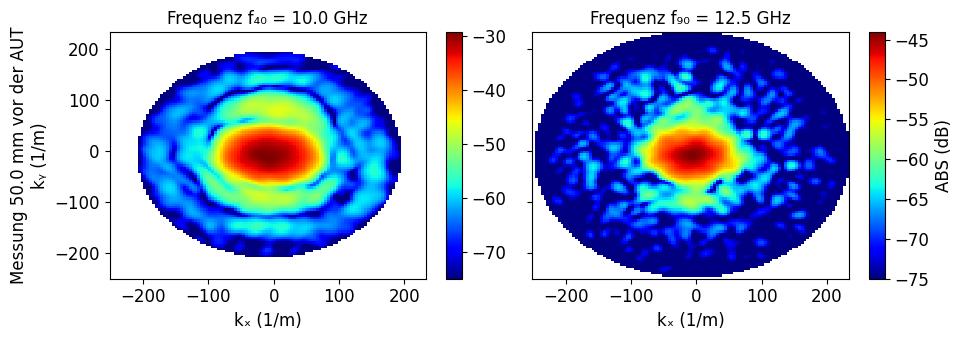

abs_50-0mm_10-0_12-5ghz


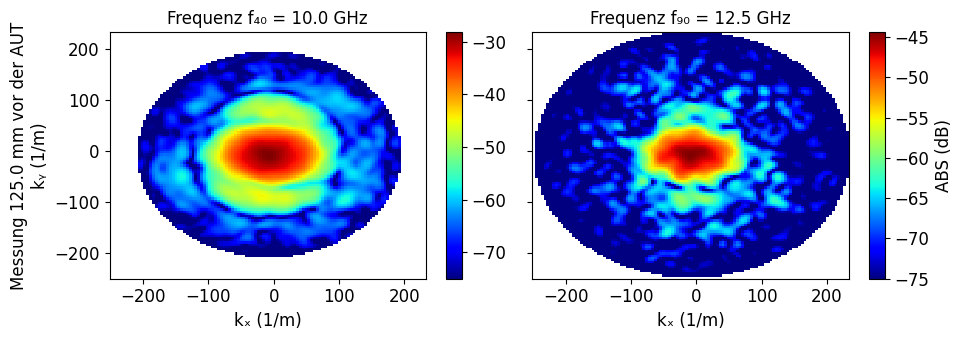

abs_125-0mm_10-0_12-5ghz


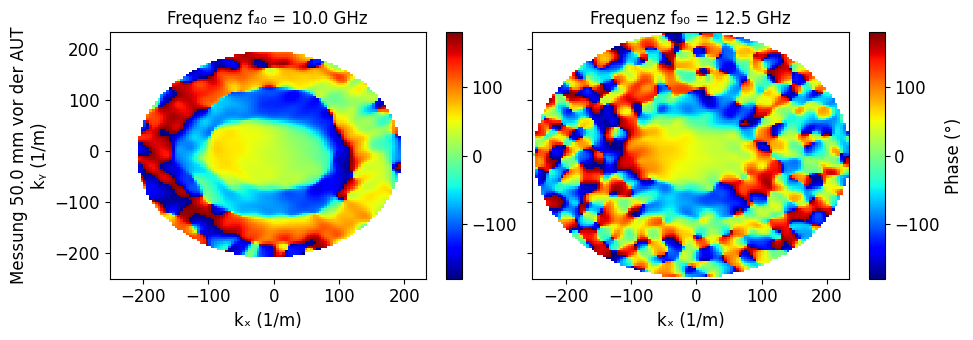

phase_50-0mm_10-0_12-5ghz


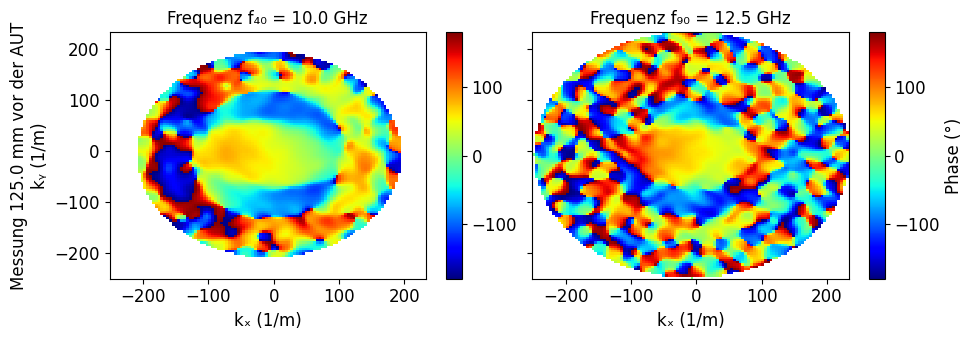

phase_125-0mm_10-0_12-5ghz
Zero-Padding

The first line of the following plot shows the measurement of a measuring plane in magnitude and phase and in the second line its FFT. Line three shows the embedding of the measuring field in zeros and line four the resulting finer resolution



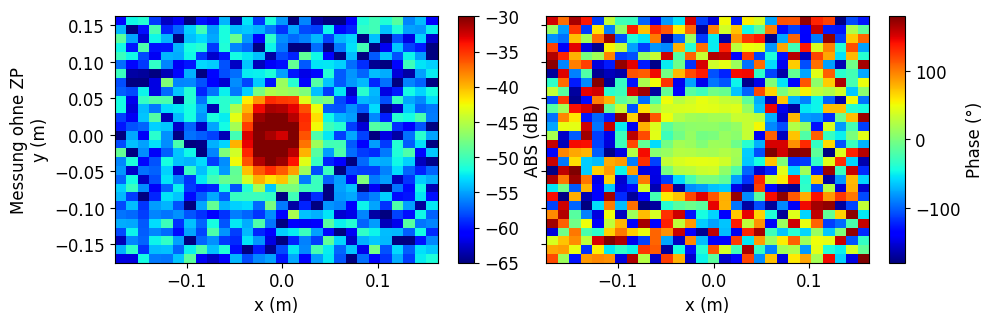

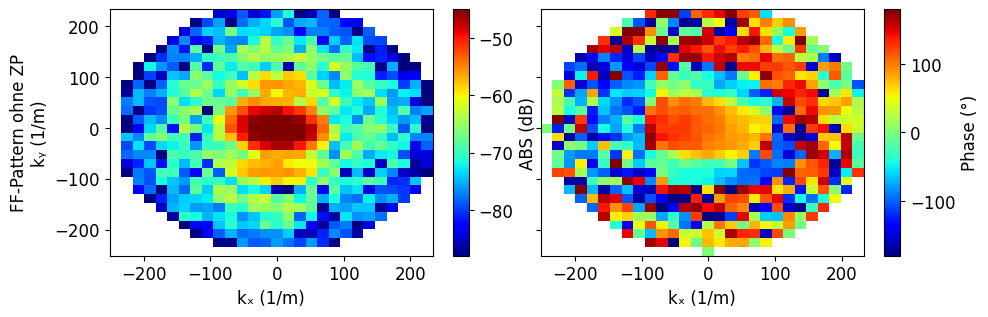

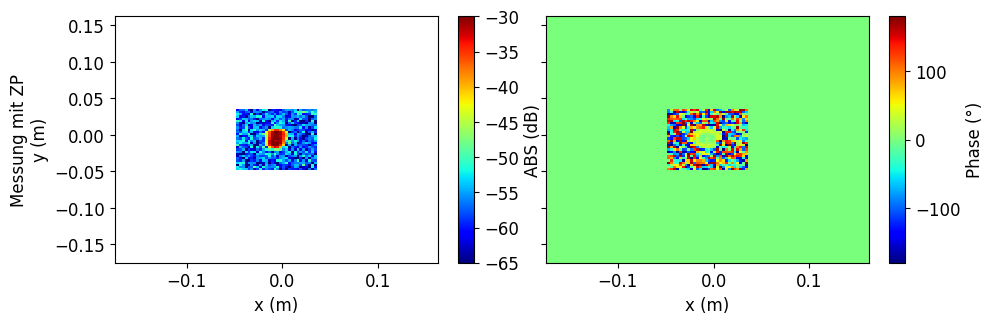

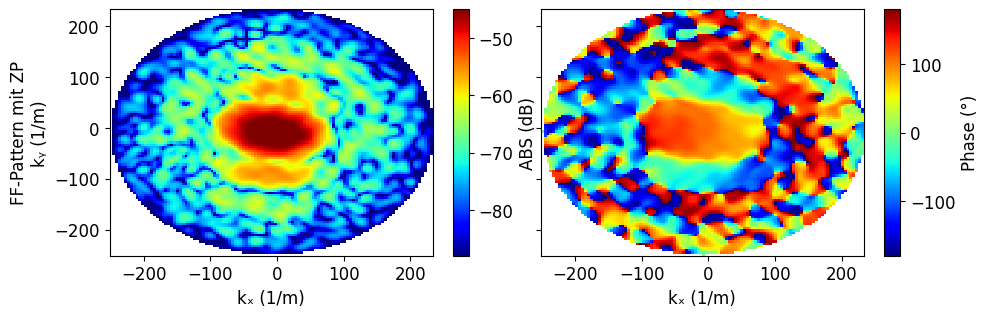

Plane-shifting

In the following plot, the first line shows two measurement-phase-representations which has different distances between the measurement plane and the AUT. Row two shows their amplitude spectrums without a phase shift and the third row shows a comparison of the two amplitude spectra after they where moved to the reference plane



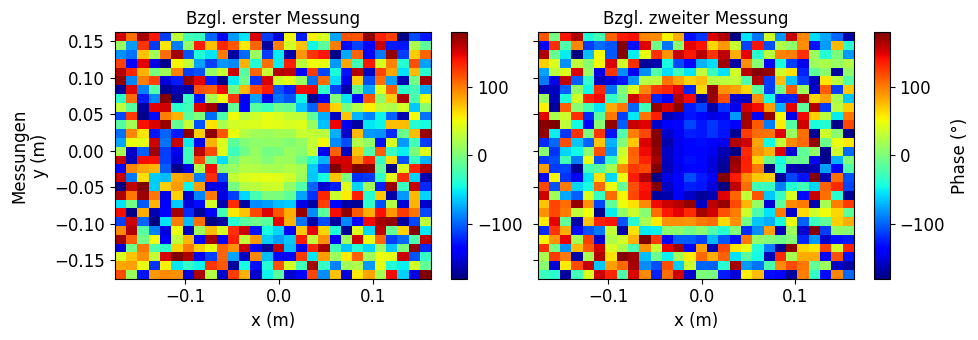

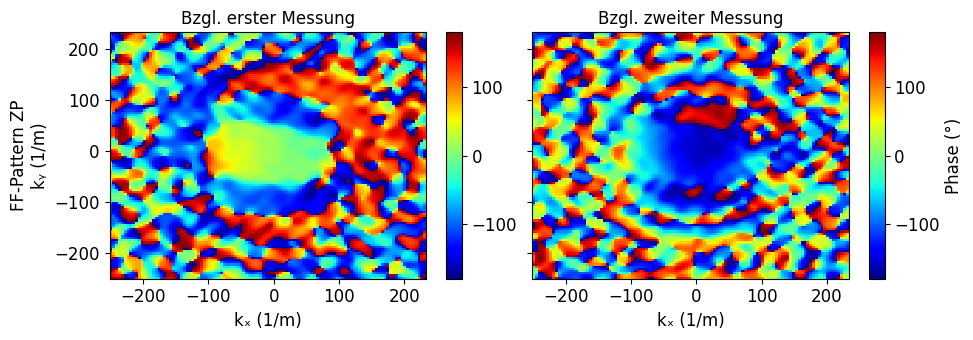

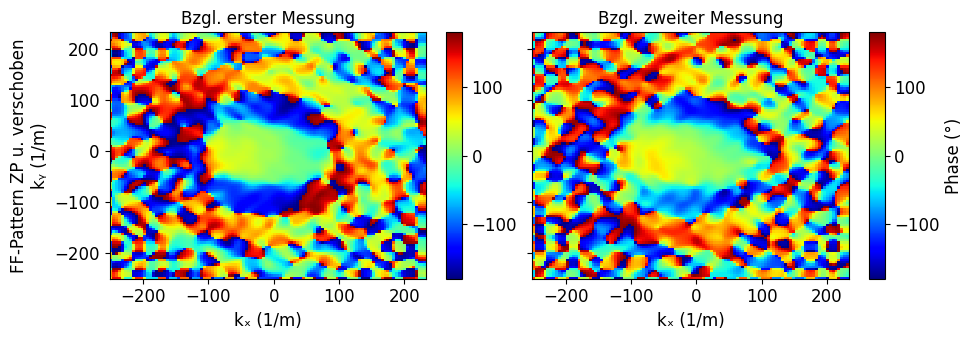

Outdated interpolation method

The following plots show an first approach of the interpolation of scatterd points. The theta and phi values were calculated and placed next to their closest representant in a predefinde theta-phi-grid.



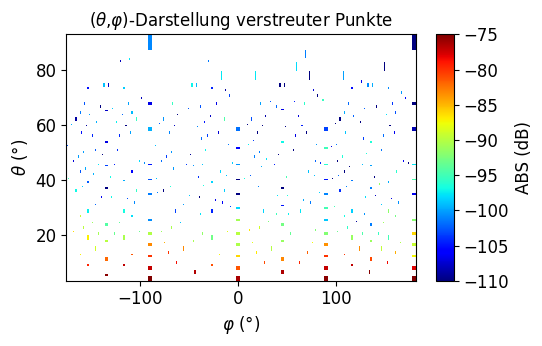

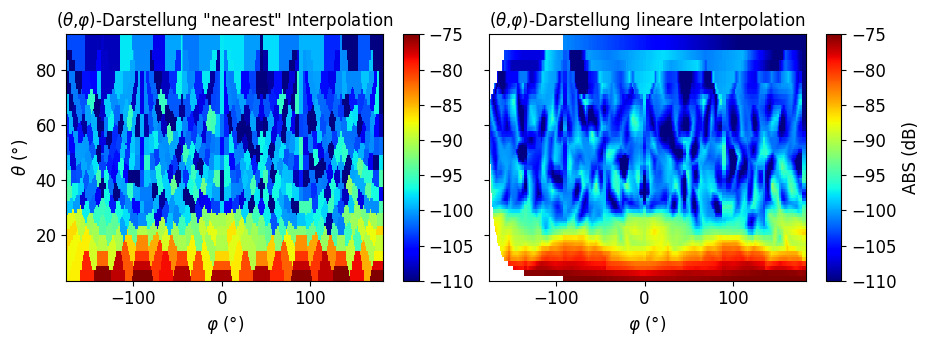

Invalid measurement-data

This segment shows all measurment-points that are filled with invalid data and based on the frequency 12 GHz.

Errors in measurement-planes:
Measurementplane@37.5mm, Polarisation Ey, Punktindex [17][22]
Measurementplane@62.5mm, Polarisation Ey, Punktindex [9][19]
Measurementplane@75mm, Polarisation Ey, Punktindex [21][23]
Measurementplane@100mm, Polarisation Ey, Punktindex [3][11]
Measurementplane@100mm, Polarisation Ex, Punktindex [5][27]
Measurementplane@100mm, Polarisation Ex, Punktindex [26][3]
Measurementplane@100mm, Polarisation Ex, Punktindex [26][18]
Measurementplane@125mm, Polarisation Ex, Punktindex [15][21]
Measurementplane@125mm, Polarisation Ex, Punktindex [16][7]
Measurementplane@125mm, Polarisation Ex, Punktindex [27][1]

Comparing FF-patterns of two different measurement-distances

The following plot shows a comparison of the FF-pattern of the measurement at a distance of 75 mm with the measurement at a distance of 125 mm between the measuremen

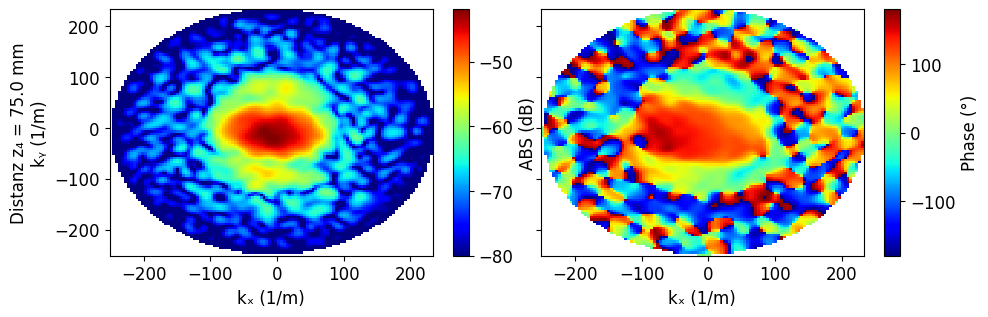

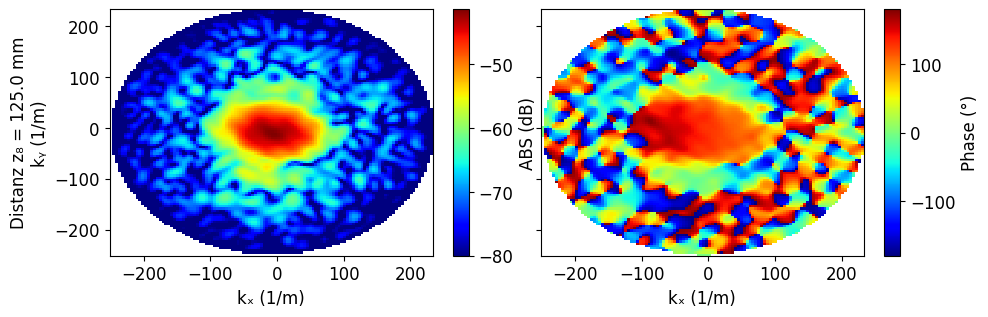

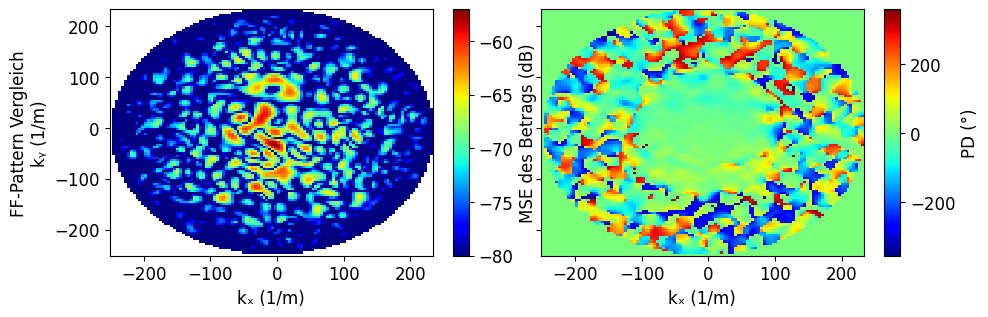

Comparison of the planar measurement at 25 mm to all the others

The following bar charts show the comparison of the ff-pattern from 25 mm to all the ohters which is kind of a figure of merit for the planar measurements.
There are also bar charts with averaged polarisation-factors for magnitude and phase.



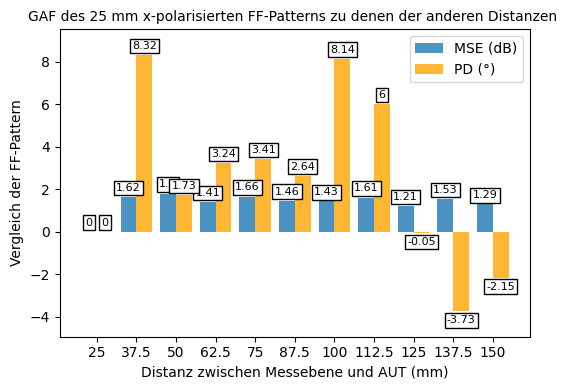

gaf-des-25-mm-x-polarisierten-ff-patterns-zu-denen-der-anderen-distanzen


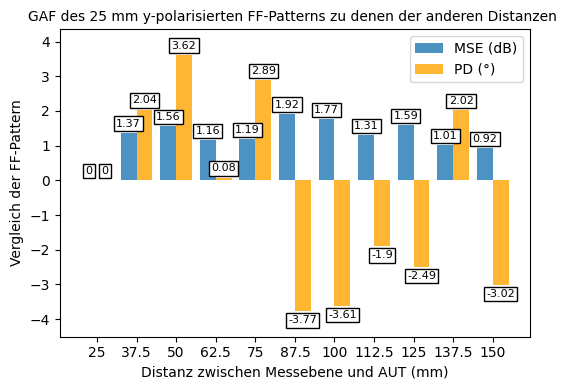

gaf-des-25-mm-y-polarisierten-ff-patterns-zu-denen-der-anderen-distanzen


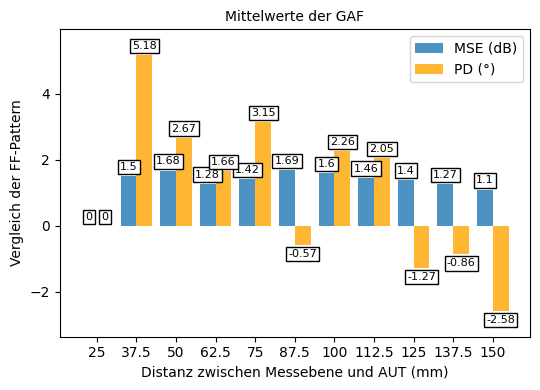

mittelwerte-der-gaf
Comparison of SOTA-measurement and a transformed planar measurement

The result of this procedure for the two orthogonal so-called parallel and cross-polarizations (p- and c-polarizations) of the electric field, is shown in the second row of the following plot. The first line shows the result of the SOTA measurement. In order to be able to compare these two results, they are maximum amplitude normalized. The third line shows the result of such a comparison.



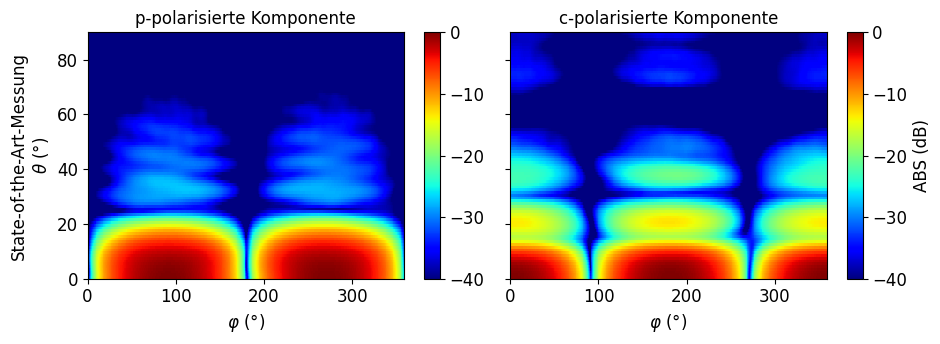

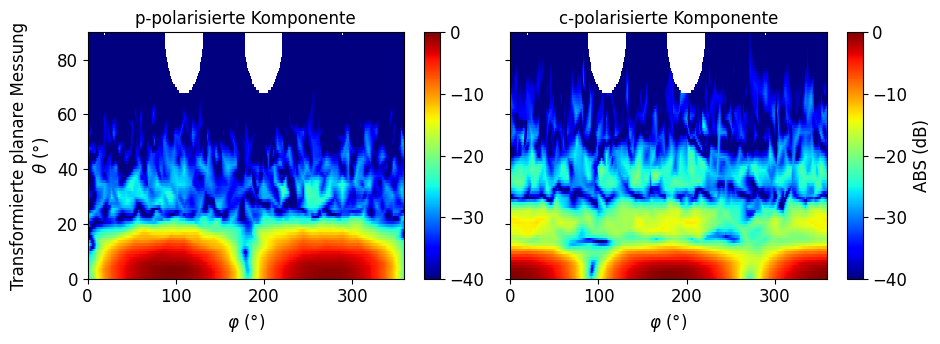

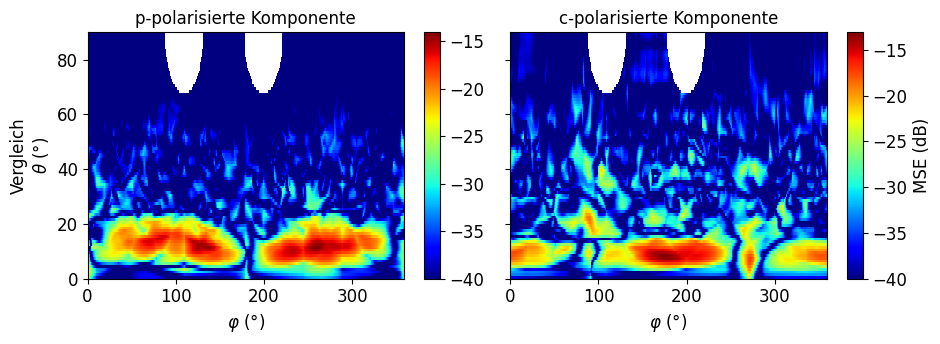

Comparison of SOTA-measurement to all transformed planar measurements

The following bar charts represents the comparison-factor of the two polarisations of a spheric measurment. There are charts for magnitudes and phases.
There are also barcharts with averaged polarisation-factors for magnitude and phase.



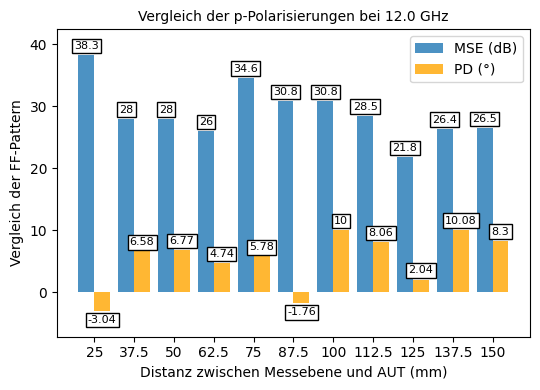

vergleich-der-p-polarisierungen-bei-12-0-ghz


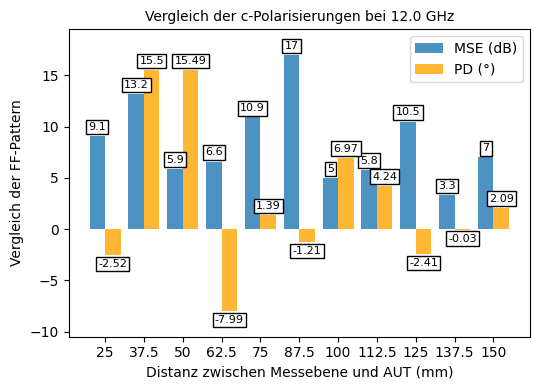

vergleich-der-c-polarisierungen-bei-12-0-ghz


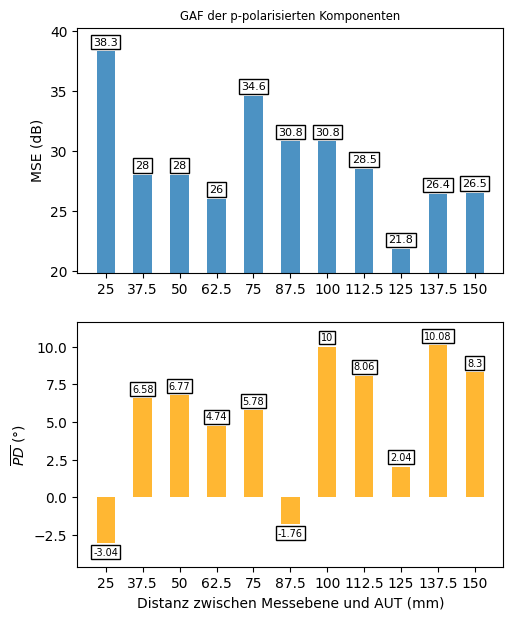

gaf-der-p-polarisierten-komponenten


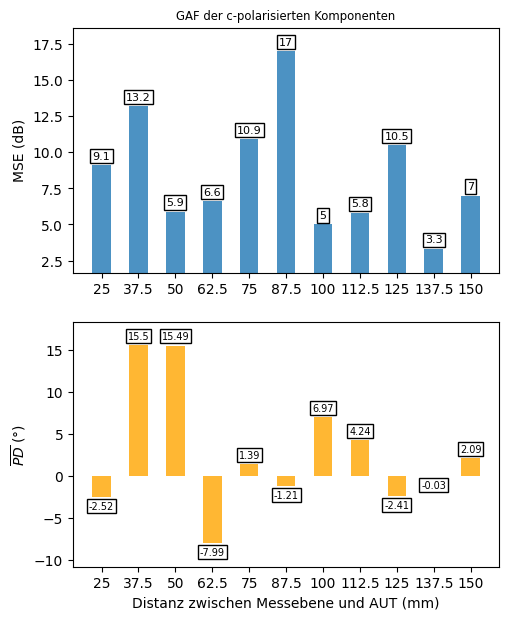

gaf-der-c-polarisierten-komponenten


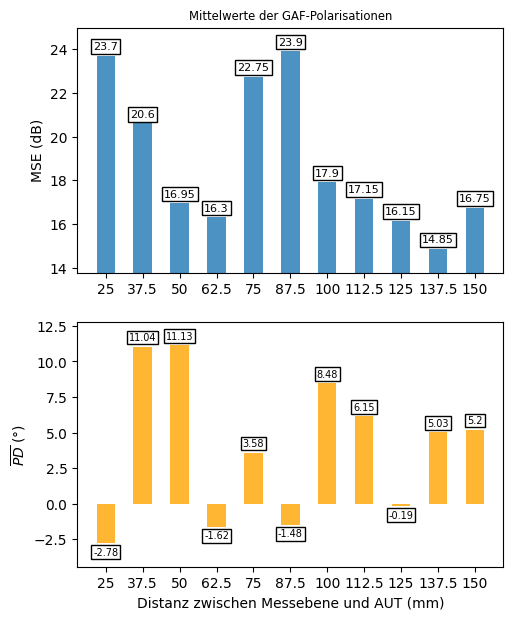

mittelwerte-der-gaf-polarisationen


In [91]:
# class for text highlighting in print-funtions
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    

# Get all planar measurements based on the frequency 12 GHz
measurements = readMeasurmentData()
measurementsInComplex = transformMeasurmentsToComplex(measurements, 80)
    

    
    

'''
Excecution: Comparison of different frequencies
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Comparison of different frequencies\n"+color.END+color.END)
print("In the following plot the frequencies 10 GHz and 12.5 GHz are represented. The first two rows show the electric field magnitudes of the FF patterns of two distances. The columns are representative of the two different frequencies. The the same pattern is repeated in the block of four below with regard to the phase.")
print()

#frequencies = [0, 40, 80] # 8GHz, 10GHz and 12GHz
#distances = [0, 1, 2]
# for i in range(2):
#     plotComparisonOfThreeFrequencies(frequencies, i, ptype='ABS', store=False)
#     plotComparisonOfThreeFrequencies(frequencies, i, ptype='phase', store=False)

distances = [2,8]
#for distance in distances:
storeFlag = False
plotComparisonOfTwoFrequencies([40,90],distances[0],ptype='ABS',store=storeFlag)
plotComparisonOfTwoFrequencies([40,90],distances[1],ptype='ABS',store=storeFlag)
plotComparisonOfTwoFrequencies([40,90],distances[0],ptype='phase',store=storeFlag)
plotComparisonOfTwoFrequencies([40,90],distances[1],ptype='phase',store=storeFlag)






'''
Excecution: Presentation of zero-padding
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Zero-Padding\n"+color.END+color.END)
print("The first line of the following plot shows the measurement of a measuring plane in magnitude and phase and in the second line its FFT. Line three shows the embedding of the measuring field in zeros and line four the resulting finer resolution")
print()

measurements = readMeasurmentData()
measurement1 = getSpecificMeasurement(measurements, distance=0, frequency=80)
measurement1ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement1[0],calculateMeasurementDistance(0, mm=False), caluclateFrequencyFromIndex(80,GHz=False))

amplitudeSpec1 = aquireAmplitudeSpectrum(measurement1ToAUT)
amplitudeSpec1_onlyPadded = getZeroPaddedArray(measurement1ToAUT,3)
amplitudeSpec1_zeroPadded = zeroPadding(measurement1ToAUT,3)

ffPatternFrom1 = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec1)
ffPatternFrom1_zeroPadded = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpec1_zeroPadded)

storeFlag = False
plotDataRepresentation(measurement1[0],"Messung ohne ZP",kSpace=False,clim=[-65,-30],store=storeFlag)
plotDataRepresentation(ffPatternFrom1,"FF-Pattern ohne ZP",kSpace=True,clim=[-45,-80],store=storeFlag)
plotDataRepresentation(amplitudeSpec1_onlyPadded,"Messung mit ZP",kSpace=False,clim=[-65,-30],store=storeFlag)
plotDataRepresentation(ffPatternFrom1_zeroPadded,"FF-Pattern mit ZP",kSpace=True,clim=[-45,-80],store=storeFlag)






'''
Excecution: Presentation of plane-shifting
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Plane-shifting\n"+color.END+color.END)
print("In the following plot, the first line shows two measurement-phase-representations which has different distances between the measurement plane and the AUT. Row two shows their amplitude spectrums without a phase shift and the third row shows a comparison of the two amplitude spectra after they where moved to the reference plane")
print()

measurement2 = getSpecificMeasurement(measurements, distance=7, frequency=80)

amplitudeSpec1 = aquireAmplitudeSpectrum(measurement1[0])
amplitudeSpec2 = aquireAmplitudeSpectrum(measurement2[0])
#plotPhaseComparisonOf2Arrays(amplitudeSpec1, amplitudeSpec2, title="Amplitude spectrums of arrays", kSpace=True, clim=None)

measurement2ToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement2[0],calculateMeasurementDistance(7, mm=False), caluclateFrequencyFromIndex(80,GHz=False))
#plotPhaseComparisonOf2Arrays(measurement1ToAUT, measurement2ToAUT, title="Amplitude spectrums of shifted arrays", kSpace=True, clim=None)

# Pad stuff
measurement1_zeroPadded = zeroPadding(measurement1[0],3)
measurement1ToAUT_zeroPadded = zeroPadding(measurement1ToAUT,3)
measurement2_zeroPadded = zeroPadding(measurement2[0],3)
measurement2ToAUT_zeroPadded = zeroPadding(measurement2ToAUT,3)

# Use padded stuff
storeFlag = False
plotPhaseComparisonOf2Arrays(measurement1[0], measurement2[0], title="Messungen", kSpace=False, clim=None, store=storeFlag)
plotPhaseComparisonOf2Arrays(measurement1_zeroPadded, measurement2_zeroPadded, title="FF-Pattern ZP", kSpace=True, clim=None, store=storeFlag)
plotPhaseComparisonOf2Arrays(measurement1ToAUT_zeroPadded, measurement2ToAUT_zeroPadded, title="FF-Pattern ZP u. verschoben", kSpace=True, clim=None, store=storeFlag)






'''
Excecution: Showing (outdated) interpolation of scattered points
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Outdated interpolation method\n"+color.END+color.END)
print("The following plots show an first approach of the interpolation of scatterd points. The theta and phi values were calculated and placed next to their closest representant in a predefinde theta-phi-grid.")
print()

# Get frequency
frequency = caluclateFrequencyFromIndex(80,GHz=False)

# Get measurment-data of specific distance (75mm, Ex)
measurement75mm = measurementsInComplex[4][0]
measurement75mm = removeSingularitiesFromData(measurement75mm)
distance2 = round(calculateMeasurementDistance(4, mm=False),3)

# Shift it to the aperture plane of the AUT
measurement75mmToAUT = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement75mm,distance2,frequency)
amplitudeSpecOf75mmToAUT = aquireAmplitudeSpectrum(measurement75mmToAUT)

# create a zero-padded amplitude spectrum
resolution = 5
amplitudeSpecOf75mmToAUT_zeroPadded = zeroPadding(measurement75mmToAUT,resolution)
ffpattern = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpecOf75mmToAUT)
ffpattern_zp = calculateElectricalFieldVectorsForSpecifcR(amplitudeSpecOf75mmToAUT_zeroPadded)

# Reshape x-y-pattern to theta-phi-pattern
# Create linespaces with a certain resolution
abs1, thetaLin1, phiLin1 = createThetaPhiArrayRepresentation(ffpattern, phase=False)
abs2, thetaLin2, phiLin2 = createThetaPhiArrayRepresentation(ffpattern_zp, phase=False)
#plotArrayWithSpecificMeshgrid(abs1, abs2, thetaLin1, phiLin1, thetaLin2, phiLin2, phase=False, clim=[-90,-45], store=True)

angles1, thetaLin1, phiLin1 = createThetaPhiArrayRepresentation(ffpattern, phase=True)
angles2, thetaLin2, phiLin2 = createThetaPhiArrayRepresentation(ffpattern_zp, phase=True)
#plotArrayWithSpecificMeshgrid(angles1, angles2, thetaLin1, phiLin1, thetaLin2, phiLin2, phase=True, clim=None, store=False)

plotComparisonOfScatteredWithInterpolatedData(amplitudeSpecOf75mmToAUT, phase=False, clim=[-110,-75], store=False)






'''
Excecution: Presentation of replacement of invalid measurement-points
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Invalid measurement-data\n"+color.END+color.END)
print("This segment shows all measurment-points that are filled with invalid data and based on the frequency 12 GHz.")
print()

print('Errors in measurement-planes:')
checkAllMeasurmentsForInvalidData(measurementsInComplex)
print()

# Get measurment-data of specific distance (100mm, Ex)
#measurement100mmEx = measurementsInComplex[6][0]
# Get measurment-data of specific distance (100mm, Ey)
#measurement100mmEy = measurementsInComplex[6][1]
# Get measurment-data of specific distance (75mm, Ex)
#measurement75mmEx = measurementsInComplex[4][0]

# Remove Errors:
#print('\nFound singularities to replace')
#result1 = removeSingularitiesFromData(measurement100mmEx)
#result2 = removeSingularitiesFromData(measurement100mmEy)
#result3 = removeSingularitiesFromData(measurement75mmEx)

#print('\nErrors in measurement-planes after calculating means for 100mm:')
#checkAllMeasurmentsForInvalidData(measurementsInComplex)

#print('\nChangement in arrays')
#print('x-Polaristaion of 100m measurement: '+str(not np.array_equal(result1,measurement100mmEx)))
#print('y-Polaristaion of 100m measurement: '+str(not np.array_equal(result2,measurement100mmEy)))

#difference1 = result1-measurement100mmEx
#difference1[difference1==0] = float('NaN')

#plotMeasurementSingularities(measurement100mmEx, title="Ex-polarisation @ 100mm", phase=True, kSpace=False, clim=[-180,180], store=True)






'''
Excecution: Representation of the comparison of two FF-patters.
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Comparing FF-patterns of two different measurement-distances\n"+color.END+color.END)
print("The following plot shows a comparison of the FF-pattern of the measurement at a distance of 75 mm with the measurement at a distance of 125 mm between the measurement plane and AUT according to magnitude and phase. The left column is representative for the magnitudes and the right for the phases. The first two lines represent the two different measuring distances. Line three shows the MSE and PD in each node.")
print()

# Get measurment-data of specific distance (75mm, Ex) and (50mm, Ex)
measurement75mmEx = measurementsInComplex[4][0]
measurement50mmEx = measurementsInComplex[2][0]
measurement125mmEx = measurementsInComplex[8][0]

# Measurement-distances
distance75 = calculateMeasurementDistance(4, mm=False)
distance50 = calculateMeasurementDistance(2, mm=False)
distance125 = calculateMeasurementDistance(8, mm=False)

# Used frequency
frequency = caluclateFrequencyFromIndex(80,GHz=False)

# Remove sigularities from measurement-plane
#measurement75mmEx = removeSingularitiesFromData(measurement75mmEx)
#measurement125mmEx = removeSingularitiesFromData(measurement125mmEx)

# Shift plane to reference-plane at AUT-aperture
shifted75mm = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement75mmEx, distance75, frequency)
shifted50mm = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement50mmEx, distance50, frequency)
shifted125mm = correctFieldDataCorrespondingToDistanceBetweenAUTandMeasurementPlane(measurement125mmEx, distance125, frequency)

# Evaluate FF-Pattern
ff_shifted75mm = calculateElectricalFieldVectorsForSpecifcR(aquireAmplitudeSpectrum(shifted75mm))
ff_shifted50mm = calculateElectricalFieldVectorsForSpecifcR(aquireAmplitudeSpectrum(shifted50mm))
ff_shifted125mm = calculateElectricalFieldVectorsForSpecifcR(aquireAmplitudeSpectrum(shifted125mm))

# Zero-padding
shifted75mm_zp = zeroPadding(shifted75mm,3)
shifted50mm_zp = zeroPadding(shifted50mm,3)
shifted125mm_zp = zeroPadding(shifted125mm,3)

# Evaluate FF-Pattern
ff_shifted75mm_zp = calculateElectricalFieldVectorsForSpecifcR(shifted75mm_zp)
ff_shifted50mm_zp = calculateElectricalFieldVectorsForSpecifcR(shifted50mm_zp)
ff_shifted125mm_zp = calculateElectricalFieldVectorsForSpecifcR(shifted125mm_zp)

# Replace NaNs with zeros
np.nan_to_num(ff_shifted75mm_zp,0)
np.nan_to_num(ff_shifted50mm_zp,0)
np.nan_to_num(ff_shifted125mm_zp,0)

# Calculate comparison of them and their zero-paded comparison
comparison75to125mm = getPercentualDifferenceOfTwoArraysElementwise(shifted75mm, shifted125mm, phase=True)
comparison75to125mm_zp = getPercentualDifferenceOfTwoArraysElementwise(ff_shifted75mm_zp, ff_shifted125mm_zp, phase=True)

# Cut off invalid data
comparison75to125mm = defineBordersOfAmplitudeSpectrumRelatedToFrequency(comparison75to125mm, frequency)
comparison75to125mm_zp = defineBordersOfAmplitudeSpectrumRelatedToFrequency(comparison75to125mm_zp, frequency)

plotComparisonOfTwoMeasurements(ff_shifted75mm_zp, ff_shifted125mm_zp, 4, 8, frequency=frequency, clim=-80, dB=True, store=False)
#plotComparisonOfTwoMeasurements(ff_shifted50mm, ff_shifted75mm, 2, 4, frequency=frequency, norm=False, percentage=False, store=False)






'''
Excecution: Bar charts for the comparison of FFPs of planar-measurements
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Comparison of the planar measurement at 25 mm to all the others\n"+color.END+color.END)
print("The following bar charts show the comparison of the ff-pattern from 25 mm to all the ohters which is kind of a figure of merit for the planar measurements.")
print("There are also bar charts with averaged polarisation-factors for magnitude and phase.")
print()

# list of distances for x-axe
distances = [25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 137.5, 150] # mm
#plotBarChart(distances, absFactors, phaseFactors)
xComponentFactors, yComponentFactors = plotComparisonBarChartsOfAllMeasurementDistances(80, comparisons=1, store=True)

# Create numpy-arrays
xComponentFactors = np.array(xComponentFactors)
yComponentFactors = np.array(yComponentFactors)

averageMagnitudes = (xComponentFactors[0][0] + yComponentFactors[0][0])/2
averagePhases = (xComponentFactors[0][1] + yComponentFactors[0][1])/2

#print(averageMagnitudes)
#print(averagePhases)

plotBarChart(distances, averageMagnitudes, averagePhases, title="Mittelwerte der GAF", store=True)






'''
Execution: Presentation of a transformed planar FFP to the spherical SOTA-measurement
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Comparison of SOTA-measurement and a transformed planar measurement\n"+color.END+color.END)
print("The result of this procedure for the two orthogonal so-called parallel and cross-polarizations (p- and c-polarizations) of the electric field, is shown in the second row of the following plot. The first line shows the result of the SOTA measurement. In order to be able to compare these two results, they are maximum amplitude normalized. The third line shows the result of such a comparison.")
print()

# Get measurment-data of specific distance (75mm, Ex) and (50mm, Ex) an (80mm, Ex)
measurement75mmEx = measurementsInComplex[4][0]
measurement50mmEx = measurementsInComplex[2][0]
measurement125mmEx = measurementsInComplex[8][0]

# Measurement-distances
distance75 = calculateMeasurementDistance(4, mm=False)
distance50 = calculateMeasurementDistance(2, mm=False)
distance125 = calculateMeasurementDistance(8, mm=False)

# Used frequency
frequency = caluclateFrequencyFromIndex(80,GHz=False)

# Get x and y polarisation of 50mm measurement plane
pol_Ex = measurementsInComplex[2][0]
pol_Ey = measurementsInComplex[2][1]

# Get x and y polarisation of 25mm measurement plane
pol_Ex_2 = measurementsInComplex[0][0]
pol_Ey_2 = measurementsInComplex[0][1]

distance50 = calculateMeasurementDistance(2, mm=False)
distance25 = calculateMeasurementDistance(0, mm=False)
frequency = caluclateFrequencyFromIndex(80,GHz=False)

ffPattern_Ex_2 = getFarFieldPattern(pol_Ex, distance=distance50, frequency=frequency, zp=0, r=0)
ffPattern_Ey_2 = getFarFieldPattern(pol_Ey, distance=distance50, frequency=frequency, zp=0, r=0)

ffPattern_Ex = getFarFieldPattern(pol_Ex_2, distance=distance25, frequency=frequency, zp=0, r=0)
ffPattern_Ey = getFarFieldPattern(pol_Ey_2, distance=distance25, frequency=frequency, zp=0, r=0)

path = r"C:\Users\Manum\OneDrive\01_TU_Wien\01_TU_Aktuell\Bachelorarbeit\02_Thema_Antennenmessung_mittels_Nah_zu_Fernfeldtransformation\12_State-of-the-Art-Messung\json_data"
filename_p = r"\ffData_12-0GHz_p.json"
fullpath_p = path+filename_p
filename_x = r"\ffData_12-0GHz_x.json"
fullpath_x = path+filename_x

measurementDicts_p = readJsonFile(fullpath_p)
magnitudes_p = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_p, phase=False)
phases_p = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_p, phase=True)

measurementDicts_x = readJsonFile(fullpath_x)
magnitudes_x = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_x, phase=False)
phases_x = assignSphericMeasurementsToThetaPhiGrid(measurementDicts_p, phase=True)

complexRep_p = createComplexRepresentationOfMagnitudeAndPhase(magnitudes_p, phases_p, dB=True, deg=True)
complexRep_x = createComplexRepresentationOfMagnitudeAndPhase(magnitudes_x, phases_x, dB=True, deg=True)
complexRep_p = complexRep_p/np.nanmax(np.abs(complexRep_p))
complexRep_x = complexRep_x/np.nanmax(np.abs(complexRep_x))
complexRep_p, complexRep_x = shiftMeasurement(complexRep_p, complexRep_x, 23)

E_p_1, E_x_1 = interpolateFFPatternToSphericGrid(ffPattern_Ex=ffPattern_Ex, ffPattern_Ey=ffPattern_Ey, frequency=12*10**9)
E_p_2, E_x_2 = interpolateFFPatternToSphericGrid(ffPattern_Ex=ffPattern_Ex_2, ffPattern_Ey=ffPattern_Ey_2, frequency=12*10**9)

max_planar_p = np.nanmax(np.abs(E_p_1))
max_planar_x = np.nanmax(np.abs(E_x_1))
E_p_1, E_x_1 = shiftMeasurement(E_p_1/max_planar_p, E_x_1/max_planar_x, 20+90)

mse, phase_difference, magnitudeFactor, phaseFactor = getPercentualDifferenceOfTwoArrays(complexRep_x, E_p_1, deviationInDB=True)
mse_2, phase_difference_2, magnitudeFactor_2, phaseFactor_2 = getPercentualDifferenceOfTwoArrays(complexRep_p, E_x_1, deviationInDB=True)


### Testing
# plot sota-measurement-data
#plotSphericalRepresentation(np.abs(complexRep_x), dB=True, clim=-40)
#plotSphericalRepresentation(np.abs(E_p_1), dB=True, clim=-40)

#plotSphericalRepresentation(mse, dB=False, clim=-40)
#print(magnitudeFactor)

# plotSphericalRepresentation(phase_difference, dB=False, clim=[-180,180])
#print(phaseFactor)


#plot transformed planar ffpattern-data
#plotSphericalRepresentation(np.abs(complexRep_p), dB=True, clim=-40)
#plotSphericalRepresentation(np.abs(E_x_1), dB=True, clim=-40)

#plotSphericalRepresentation(mse_2, dB=False, clim=-40)
#print(magnitudeFactor_2)

#plotSphericalRepresentation(phase_difference_2, dB=False, clim=[-180,180])
#print(phaseFactor_2)

# Plot next to each other
storeFlag = False
plotTwoSphericArraysNextToEachOhter(20*np.log10(np.abs(complexRep_x)), 20*np.log10(np.abs(complexRep_p)), title="State-of-the-Art-Messung", clim=-40, comparison=False, dB=True, store=storeFlag)
plotTwoSphericArraysNextToEachOhter(20*np.log10(np.abs(E_p_1)), 20*np.log10(np.abs(E_x_1)), title="Transformierte planare Messung", clim=-40, comparison=False, dB=True, store=storeFlag)
plotTwoSphericArraysNextToEachOhter(mse, mse_2, title="Vergleich", clim=-40, comparison=True, dB=True, store=storeFlag)





'''
Execution: Barcharts representing the comparisons of the SOTA-measurment to all transformed planar FFPs
'''
# Print short description
print(color.UNDERLINE+color.BOLD+"Comparison of SOTA-measurement to all transformed planar measurements\n"+color.END+color.END)
print("The following bar charts represents the comparison-factor of the two polarisations of a spheric measurment. There are charts for magnitudes and phases.")
print("There are also barcharts with averaged polarisation-factors for magnitude and phase.")
print()
p_mags, p_phases, x_mags, x_phases = plotComparisonBetweenSphericAndPlanarMeasurements(frequencyRep=80, zeroPadding=0, store=False)

mags1 = np.array(p_mags)
mags2 = np.array(x_mags)
phases1 = np.array(p_phases)
phases2 = np.array(x_phases)
# print(p_mags)
# print(p_phases)

magsAverage = np.round((mags1+mags2)/2,2)
phaseAverage = np.round((phases1+phases2)/2,2)

#print(magsAverage)
#print(phaseAverage)

distances = [25, 37.5, 50, 62.5, 75, 87.5, 100, 112.5, 125, 137.5, 150]
# Gesamtabweichungsfaktor (GAF)
storeFlag = False
plotBarChartSeperatly(distances, p_mags, p_phases, fname="GAF der p-polarisierten Komponenten", store=storeFlag)
plotBarChartSeperatly(distances, x_mags, x_phases, fname="GAF der c-polarisierten Komponenten", store=storeFlag)
plotBarChartSeperatly(distances, magsAverage, phaseAverage, fname="Mittelwerte der GAF-Polarisationen", store=storeFlag)